<a href="https://colab.research.google.com/github/geovalexis/AndroidAnimation/blob/main/notebooks/4_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Helper functions

In [ ]:
import numpy as np
import pandas as pd

def filterOutByFrequency(column: pd.Series, min_threshold: int = None, max_threshold: int = None) -> pd.Series:
    col_exploded = column.explode()
    elements_counts = col_exploded.value_counts()
    print(f"The element with the maximum number of ocurrences is {elements_counts.idxmax()} with {elements_counts.max()} ocurrences.", flush=True)
    print(f"The element with the minimum number of ocurrences is {elements_counts.idxmin()} with {elements_counts.min()} ocurrences.", flush=True)
    min_threshold = min_threshold if min_threshold else elements_counts.min()
    max_threshold = max_threshold if max_threshold else elements_counts.max()
    out_elements = elements_counts[(elements_counts<min_threshold) | (elements_counts>max_threshold)].index
    column_filtered = col_exploded[~col_exploded.isin(out_elements)].dropna().groupby(level=list(range(column.index.nlevels))).agg(list)
    return column_filtered

In [ ]:
# For translating the taxIDs to their corresponding complete names

!pip install ete3
from ete3 import NCBITaxa

def getSpeciesNames(taxa: list):
    ncbi = NCBITaxa()
    tax2names = ncbi.get_taxid_translator(taxa)
    #speciesNames = [tax2names[i] for i in taxa]
    return tax2names


In [ ]:
def sort_by_evolutionary_distance(reference_tax, taxa: list):
    taxa_list = taxa
    if reference_tax not in taxa_list: # The reference_tax must among the taxa list
      taxa_list.append(reference_tax)  
    ncbi = NCBITaxa()
    phylogenetic_tree = ncbi.get_topology(taxa_list)
    reference_tax_node = phylogenetic_tree.search_nodes(name=str(reference_tax))[0]
    distance_matrix = []
    for tax in taxa:
        tax_node = phylogenetic_tree.search_nodes(name=str(tax))[0]
        dist = phylogenetic_tree.get_distance(reference_tax_node, tax_node) 
        distance_matrix.append((tax_node.name, dist))
    sorted_by_dist = sorted(distance_matrix, key=lambda tup: tup[1])
    return [int(tup[0]) for tup in sorted_by_dist]

# Parse Phylogenetic Profiling Matrix (with GO terms)

## All species

In [ ]:
# Parse PP matrix
import pandas as pd

profiling_matrix = pd.read_table("drive/MyDrive/TFG/MtP_201601_blasted-all_proteins-include_go_parents-pp_matrix_counts_with_taxa.tab", 
                                header=0, index_col=[0,1],  
                                converters={"GO_IDs": lambda x:  list(filter(None, x.split(",")))}) # Python's split funtion does not return empty lists but lists with empty strings: [''], that is why we need to filter this cells (None)
profiling_matrix

189518  ...                                             GO_IDs
9606   Q96T66       1  ...  [GO:0006139, GO:0006725, GO:0006753, GO:000679...
       Q6IQ20       1  ...  [GO:0001523, GO:0001659, GO:0006629, GO:000664...
       Q9H3J6       2  ...                                                 []
       Q14397       1  ...  [GO:0006082, GO:0006109, GO:0006110, GO:000614...
       Q8NFV4       1  ...                                                 []
...               ...  ...                                                ...
243274 Q9X0B7       0  ...                                                 []
       Q9X1T3       0  ...                                                 []
       Q9X2C2       0  ...                                                 []
       Q9X1M4       0  ...                                                 []
       Q9X043       0  ...                                                 []

[578869 rows x 79 columns]

## Only Human Specie


In [1]:
import pandas as pd

profiling_matrix = pd.read_table("drive/MyDrive/TFG/MtP_201601_blasted-all_proteins-include_go_parents-pp_matrix_counts_with_taxa.tab", 
                                header=0, index_col=[0,1],  
                                converters={"GO_IDs": lambda x:  list(filter(None, x.split(",")))}) # Python's split funtion does not return empty lists but lists with empty strings: [''], that is why we need to filter this cells (None)
profiling_matrix = profiling_matrix.loc[9606] #For filtering by only human proteins
profiling_matrix


,189518,85962,208964,122586,83333,272561,226186,190304,324602,1111708,243230,224308,83332,100226,243273,243232,188937,64091,273057,243274,3055,3218,3702,39947,4577,284812,559292,284591,367110,665079,214684,237631,418459,237561,5664,5722,184922,36329,5888,6239,6412,6945,7070,7165,7227,7719,7739,7955,8090,8364,9031,9595,9598,9615,9913,10090,10116,13616,321614,289376,251221,35128,243231,44689,45351,224324,81824,684364,164328,243090,69014,436308,374847,515635,330879,224911,9606,7918,GO_IDs
Q96T66,1,0,1,0,1,0,1,1,1,1,0,1,1,1,0,0,0,0,0,1,1,4,0,0,1,1,2,1,1,1,0,1,1,1,1,2,0,0,0,0,1,1,1,2,1,0,1,1,0,0,0,1,1,1,1,1,0,1,1,1,1,0,1,1,1,1,1,0,1,1,0,0,0,1,1,0,0,0,"[GO:0006139, GO:0006725, GO:0006753, GO:000679..."
Q6IQ20,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,1,0,0,0,0,0,1,1,1,1,0,4,0,1,0,0,0,1,0,2,0,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,2,3,0,0,0,0,0,0,0,0,0,3,0,0,0,"[GO:0001523, GO:0001659, GO:0006629, GO:000664..."
Q9H3J6,2,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,1,0,1,0,0,0,1,1,1,1,0,1,1,1,0,1,0,1,0,1,1,1,1,1,1,1,0,1,2,1,0,2,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,[]
Q14397,1,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,1,1,0,1,1,1,0,1,1,0,1,1,1,1,2,0,0,0,0,0,0,0,0,0,0,0,"[GO:0006082, GO:0006109, GO:0006110, GO:000614..."
Q8NFV4,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,1,1,0,1,1,1,1,1,0,1,0,2,1,1,0,1,0,2,1,1,1,0,2,1,1,1,1,0,1,1,1,1,1,1,1,3,1,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,2,0,0,0,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A6NED7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,[]
M0R036,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,[]
O14598,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,[]
Q5T7P6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,[]


## Some filtering

In [ ]:
# Filter out unnotated proteins
profiling_matrix = profiling_matrix[profiling_matrix["GO_IDs"].str.len()>0]  # Drop those genes that do not have GO term (the final goal of the project is to assign them one, but to train the model we need to give it resolved examples)
profiling_matrix

In [ ]:
# Filter out GO terms does not meet a certain number of ocurrences
profiling_matrix = profiling_matrix.assign(GO_IDs=filterOutByFrequency(profiling_matrix["GO_IDs"], min_threshold=100, max_threshold=5000)).dropna()
profiling_matrix

The element with the maximum number of ocurrences is GO:0008150 with 13000 ocurrences.
The element with the minimum number of ocurrences is GO:0015692 with 1 ocurrences.


,189518,85962,208964,122586,83333,272561,226186,190304,324602,1111708,243230,224308,83332,100226,243273,243232,188937,64091,273057,243274,3055,3218,3702,39947,4577,284812,559292,284591,367110,665079,214684,237631,418459,237561,5664,5722,184922,36329,5888,6239,6412,6945,7070,7165,7227,7719,7739,7955,8090,8364,9031,9595,9598,9615,9913,10090,10116,13616,321614,289376,251221,35128,243231,44689,45351,224324,81824,684364,164328,243090,69014,436308,374847,515635,330879,224911,9606,7918,GO_IDs
Q96T66,1,0,1,0,1,0,1,1,1,1,0,1,1,1,0,0,0,0,0,1,1,4,0,0,1,1,2,1,1,1,0,1,1,1,1,2,0,0,0,0,1,1,1,2,1,0,1,1,0,0,0,1,1,1,1,1,0,1,1,1,1,0,1,1,1,1,1,0,1,1,0,0,0,1,1,0,0,0,"[GO:0006139, GO:0006725, GO:0006753, GO:000679..."
Q6IQ20,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,1,0,0,0,0,0,1,1,1,1,0,4,0,1,0,0,0,1,0,2,0,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,2,3,0,0,0,0,0,0,0,0,0,3,0,0,0,"[GO:0006629, GO:0006644, GO:0006650, GO:000672..."
Q14397,1,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,1,1,0,1,1,1,0,1,1,0,1,1,1,1,2,0,0,0,0,0,0,0,0,0,0,0,"[GO:0006082, GO:0006109, GO:0006810, GO:000681..."
O76031,1,1,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,3,3,4,3,0,1,1,1,1,0,1,0,1,0,0,0,0,0,2,1,1,1,1,1,1,1,2,0,0,1,0,1,1,1,1,1,1,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,"[GO:0006508, GO:0006807, GO:0019538, GO:004317..."
P00492,1,0,1,1,1,0,1,1,1,1,0,1,1,1,0,0,2,0,1,0,2,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,1,1,1,1,0,0,1,1,0,1,1,1,0,0,1,1,0,1,0,1,0,1,0,1,1,1,0,1,1,0,0,0,0,"[GO:0006139, GO:0006163, GO:0006164, GO:000672..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P01714,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[GO:0002252, GO:0002253, GO:0002376, GO:000242..."
Q05315,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[GO:0001817, GO:0002682, GO:0002694, GO:000269..."
Q3LHN2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[GO:0031424, GO:0032501]"
Q701N2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,"[GO:0031424, GO:0032501]"


In [ ]:
# GO terms counts
go_terms_counts = profiling_matrix["GO_IDs"].explode().value_counts()
go_terms_counts

GO:0006807    4780
GO:0048518    4590
GO:0019222    4547
GO:0043170    4148
GO:0060255    4094
              ... 
GO:1903169     100
GO:0050808     100
GO:1903708     100
GO:0032368     100
GO:1902107     100
Name: GO_IDs, Length: 997, dtype: int64

In [ ]:
# Some preanalysis of the GO terms counts as categorical values. The top is the most common value. The freq is the most common value’s frequency
go_terms_counts.astype(object).describe()

count     997
unique    511
top       136
freq       12
Name: GO_IDs, dtype: int64

In [ ]:
# Preanalysis as ints values
go_terms_counts.describe()

count     997.000000
mean      502.354062
std       677.507732
min       100.000000
25%       144.000000
50%       229.000000
75%       548.000000
max      4780.000000
Name: GO_IDs, dtype: float64

In [ ]:
# Check counts of a concrete GO term
go_terms_counts[go_terms_counts.index=="GO:0005739"] # GO:0005739 corresponds to "mitochondrion" function in Cellular Component ontology

# GO terms distribution

## GO terms distribution through the proteins of a given specie

### Matrix preparation

In [ ]:
GO_terms = profiling_matrix["GO_IDs"].explode()
GO_terms.index.rename("uniprotID", inplace=True)
GO_terms = GO_terms.reset_index()
GO_terms_distribution = GO_terms.groupby(["uniprotID", "GO_IDs"]).apply(len).unstack(fill_value=0).T
GO_terms_distribution

uniprotID,A0A075B6P5,A0A075B6S6,A0A087WT01,A0A087X1C5,A0A0A6YYK7,A0A0C4DH25,A0A0C4DH73,A0AVF1,A0AVI4,A0AVK6,A0AVT1,A0FGR8,A0FGR9,A0M8Q6,A0MZ66,A0PJK1,A0PJZ3,A0PK00,A1A4S6,A1A4Y4,A1A519,A1A5B4,A1E959,A1KZ92,A1L0T0,A1L190,A1L3X0,A1L4H1,A1X283,A1XBS5,A1YPR0,A2A288,A2IDD5,A2RRP1,A2RTX5,A2RU30,A2RU49,A2RUB1,A2RUB6,A2RUC4,...,Q9Y6M1,Q9Y6M4,Q9Y6M5,Q9Y6M7,Q9Y6N1,Q9Y6N5,Q9Y6N6,Q9Y6N7,Q9Y6N8,Q9Y6N9,Q9Y6P5,Q9Y6Q1,Q9Y6Q2,Q9Y6Q3,Q9Y6Q5,Q9Y6Q6,Q9Y6Q9,Q9Y6R0,Q9Y6R1,Q9Y6R4,Q9Y6R9,Q9Y6T7,Q9Y6U3,Q9Y6V0,Q9Y6V7,Q9Y6W3,Q9Y6W5,Q9Y6W6,Q9Y6W8,Q9Y6X2,Q9Y6X3,Q9Y6X5,Q9Y6X6,Q9Y6X8,Q9Y6X9,Q9Y6Y0,Q9Y6Y1,Q9Y6Y8,Q9Y6Y9,Q9Y6Z7
GO_IDs,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
GO:0000086,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
GO:0000122,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
GO:0000165,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
GO:0000184,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
GO:0000187,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GO:2001234,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
GO:2001236,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
GO:2001242,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Visualization

#### Static Heat Map

/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:649: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



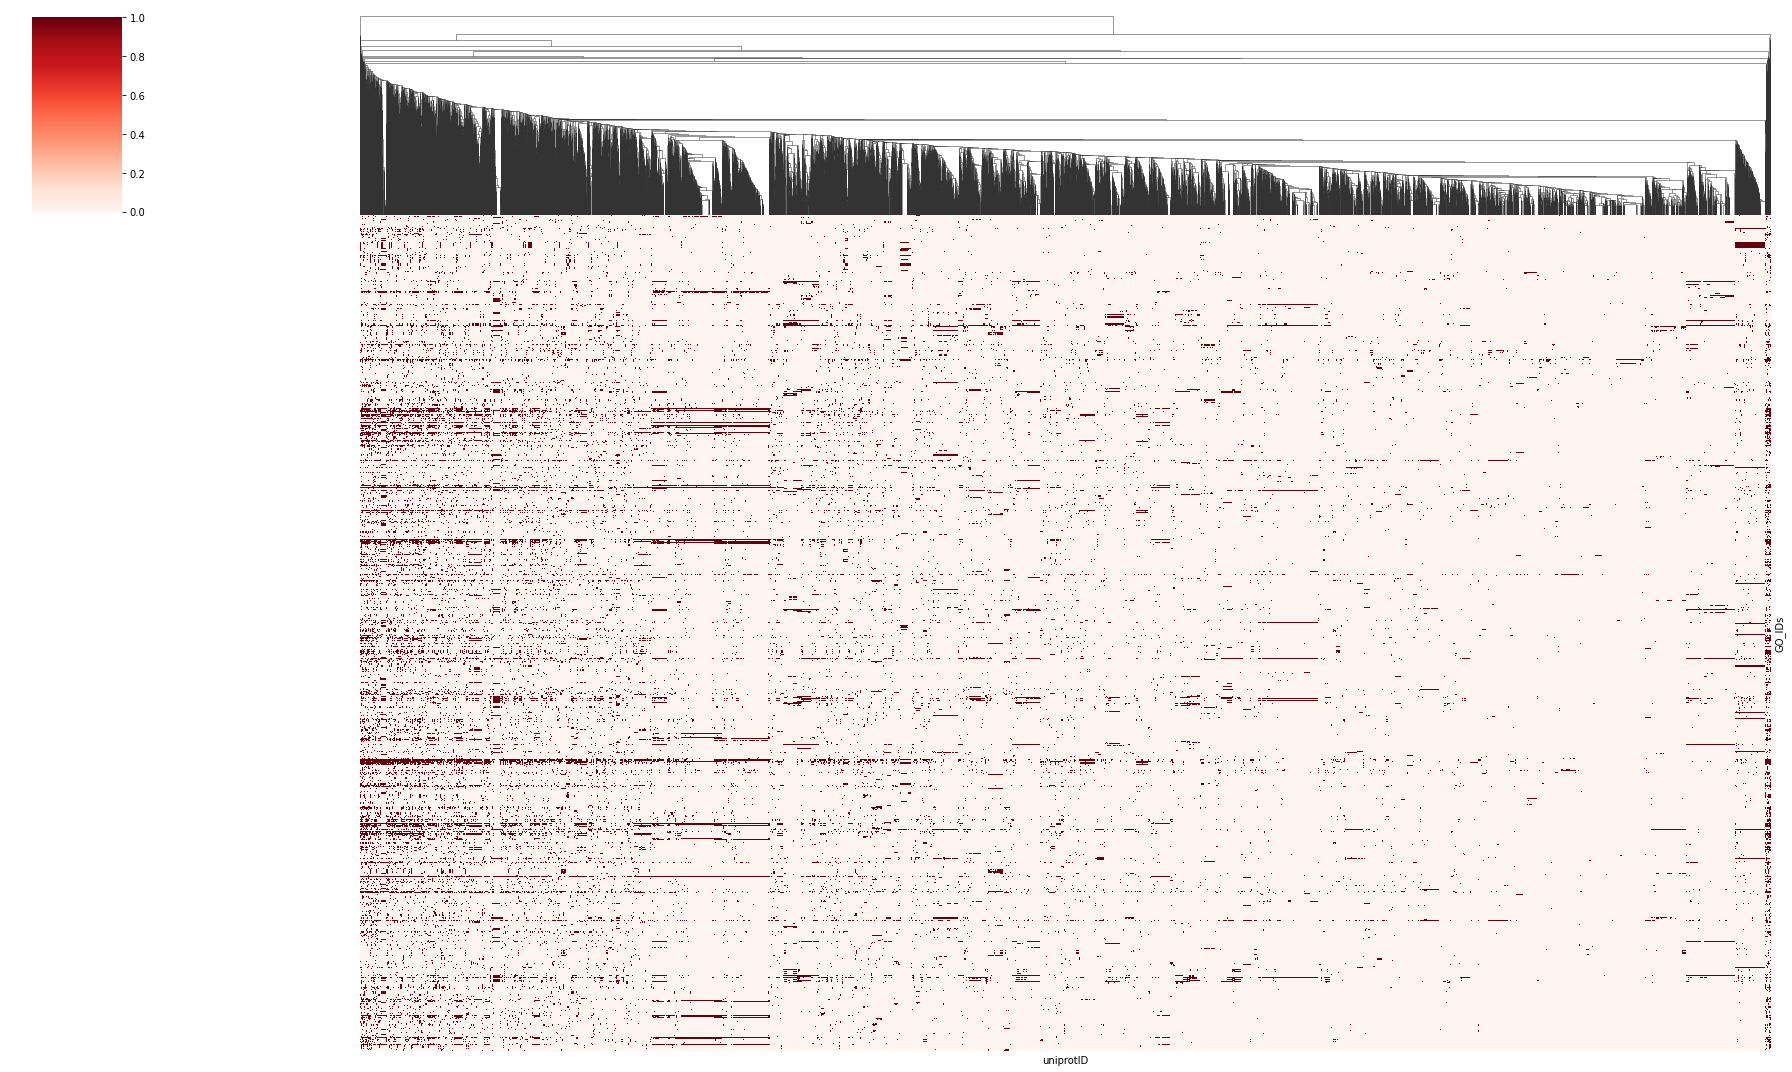

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plot = sns.clustermap(GO_terms_distribution, 
               #method='complete', metric='euclidean', 
               standard_scale=1, figsize=(25, 15), 
               row_cluster=False, col_cluster=True, 
               cmap="Reds",        # Other way sns.mpl_palette("reds",n_colors=2, as_cmap=True))
               xticklabels=0,
               yticklabels=0
               )
plot

#### Interactive Heat Map

In [ ]:
# Scaling data with sklearn
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
GO_terms_distribution_scaled = pd.DataFrame(scaler.fit_transform(GO_terms_distribution.values), columns=GO_terms_distribution.columns, index=GO_terms_distribution.index)
GO_terms_distribution_scaled

uniprotID,A0A075B6P5,A0A075B6S6,A0A087WT01,A0A087X1C5,A0A0A6YYK7,A0A0C4DH25,A0A0C4DH73,A0AVF1,A0AVI4,A0AVK6,A0AVT1,A0FGR8,A0FGR9,A0M8Q6,A0MZ66,A0PJK1,A0PJZ3,A0PK00,A1A4S6,A1A4Y4,A1A519,A1A5B4,A1E959,A1KZ92,A1L0T0,A1L190,A1L3X0,A1L4H1,A1X283,A1XBS5,A1YPR0,A2A288,A2IDD5,A2RRP1,A2RTX5,A2RU30,A2RU49,A2RUB1,A2RUB6,A2RUC4,...,Q9Y6M1,Q9Y6M4,Q9Y6M5,Q9Y6M7,Q9Y6N1,Q9Y6N5,Q9Y6N6,Q9Y6N7,Q9Y6N8,Q9Y6N9,Q9Y6P5,Q9Y6Q1,Q9Y6Q2,Q9Y6Q3,Q9Y6Q5,Q9Y6Q6,Q9Y6Q9,Q9Y6R0,Q9Y6R1,Q9Y6R4,Q9Y6R9,Q9Y6T7,Q9Y6U3,Q9Y6V0,Q9Y6V7,Q9Y6W3,Q9Y6W5,Q9Y6W6,Q9Y6W8,Q9Y6X2,Q9Y6X3,Q9Y6X5,Q9Y6X6,Q9Y6X8,Q9Y6X9,Q9Y6Y0,Q9Y6Y1,Q9Y6Y8,Q9Y6Y9,Q9Y6Z7
GO_IDs,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
GO:0000086,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GO:0000122,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
GO:0000165,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GO:0000184,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GO:0000187,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GO:2001234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GO:2001236,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GO:2001242,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Heatmap(
                   z=GO_terms_distribution_scaled.values,
                   x=GO_terms_distribution_scaled.columns,
                   y=GO_terms_distribution_scaled.index,
                   hoverongaps = False,
                   colorscale='Reds',
                   colorbar= dict(title="Intensity")
                   ))
fig.update_layout(
    title='Go terms distribution',
)
fig.update_yaxes(title="GO terms")
fig.update_xaxes(type='category', title="uniprotIDs")
fig.show()


## GO terms distribution throughout all species

Check how the GO terms are distributed around the 78 reference species set by QfO. 

**IMPORTANT**: `profiling_matrix` must correspond to matrix with multiIndex[taxa, uniprotid]

### Matrix preparation

In [ ]:
GO_terms = profiling_matrix["GO_IDs"].explode()
GO_terms.index.rename(["taxID","uniprotID"], inplace=True)
GO_terms = GO_terms.reset_index()
GO_terms_distribution = GO_terms.pivot_table(values="uniprotID", index="GO_IDs", columns="taxID", aggfunc="count", dropna=False, fill_value=0).astype(int)
GO_terms_distribution

taxID,3055,3702,4577,5664,5888,6239,6945,7070,7165,7227,7719,7739,7918,7955,8090,8364,9031,9595,9598,9606,9615,9913,10090,10116,13616,35128,36329,39947,44689,45351,64091,69014,83332,83333,85962,100226,122586,188937,189518,208964,214684,224308,224324,224911,226186,237561,237631,243230,243231,243232,243273,243274,273057,284591,284812,321614,330879,367110,436308,559292,665079,1111708
GO_IDs,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
GO:0000003,0,5,0,0,0,96,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
GO:0000045,0,2,0,1,0,5,0,0,0,7,0,0,0,5,0,2,5,0,1,30,0,7,31,13,0,0,1,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,18,0,0
GO:0000070,0,4,0,0,0,23,0,0,0,20,0,0,0,4,0,0,1,0,0,16,0,1,12,5,0,0,3,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,34,0,0,0,0,18,0,0
GO:0000082,0,3,0,0,0,2,0,0,0,7,0,0,0,3,0,0,1,0,0,78,1,6,34,17,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,4,0,0,0,0,22,0,0
GO:0000086,0,3,0,0,0,0,0,0,0,6,0,0,0,3,0,0,4,0,0,117,2,5,24,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,1,0,0,0,0,20,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GO:1901215,0,0,0,0,0,8,0,0,0,9,0,0,0,1,1,0,0,0,0,34,0,2,19,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
GO:1901796,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,125,0,0,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
GO:1902600,0,6,0,0,0,4,0,0,0,42,1,0,0,3,0,1,0,0,0,29,1,2,16,9,0,0,7,0,1,0,0,0,1,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16,0,1,0,0,13,0,0


In [ ]:
# Species without any GO term assigned
GO_terms_distribution.columns[GO_terms_distribution.mean()==0]

Int64Index([], dtype='int64', name='taxID')

### Reorder and name species

In [ ]:
# Reordered by evolutionary distance 
GO_terms_distribution = GO_terms_distribution[sort_by_evolutionary_distance(9606, list(GO_terms_distribution.columns))]

NCBI database not present yet (first time used?)
Done. Parsing...


Loading node names...
2316619 names loaded.
243028 synonyms loaded.
Loading nodes...
2316619 nodes loaded.
Linking nodes...
Tree is loaded.
Updating database: /root/.etetoolkit/taxa.sqlite ...
 2316000 generating entries... 

Inserting synonyms:      10000 


Uploading to /root/.etetoolkit/taxa.sqlite



Inserting synonyms:      240000 

Inserting taxids:       15000 

Inserting taxids:       2315000 

In [ ]:
# Translate tax IDs to names
GO_terms_distribution = GO_terms_distribution.rename(columns=getSpeciesNames(list(GO_terms_distribution.columns)))


### Visualization

#### Static Heat Map

/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


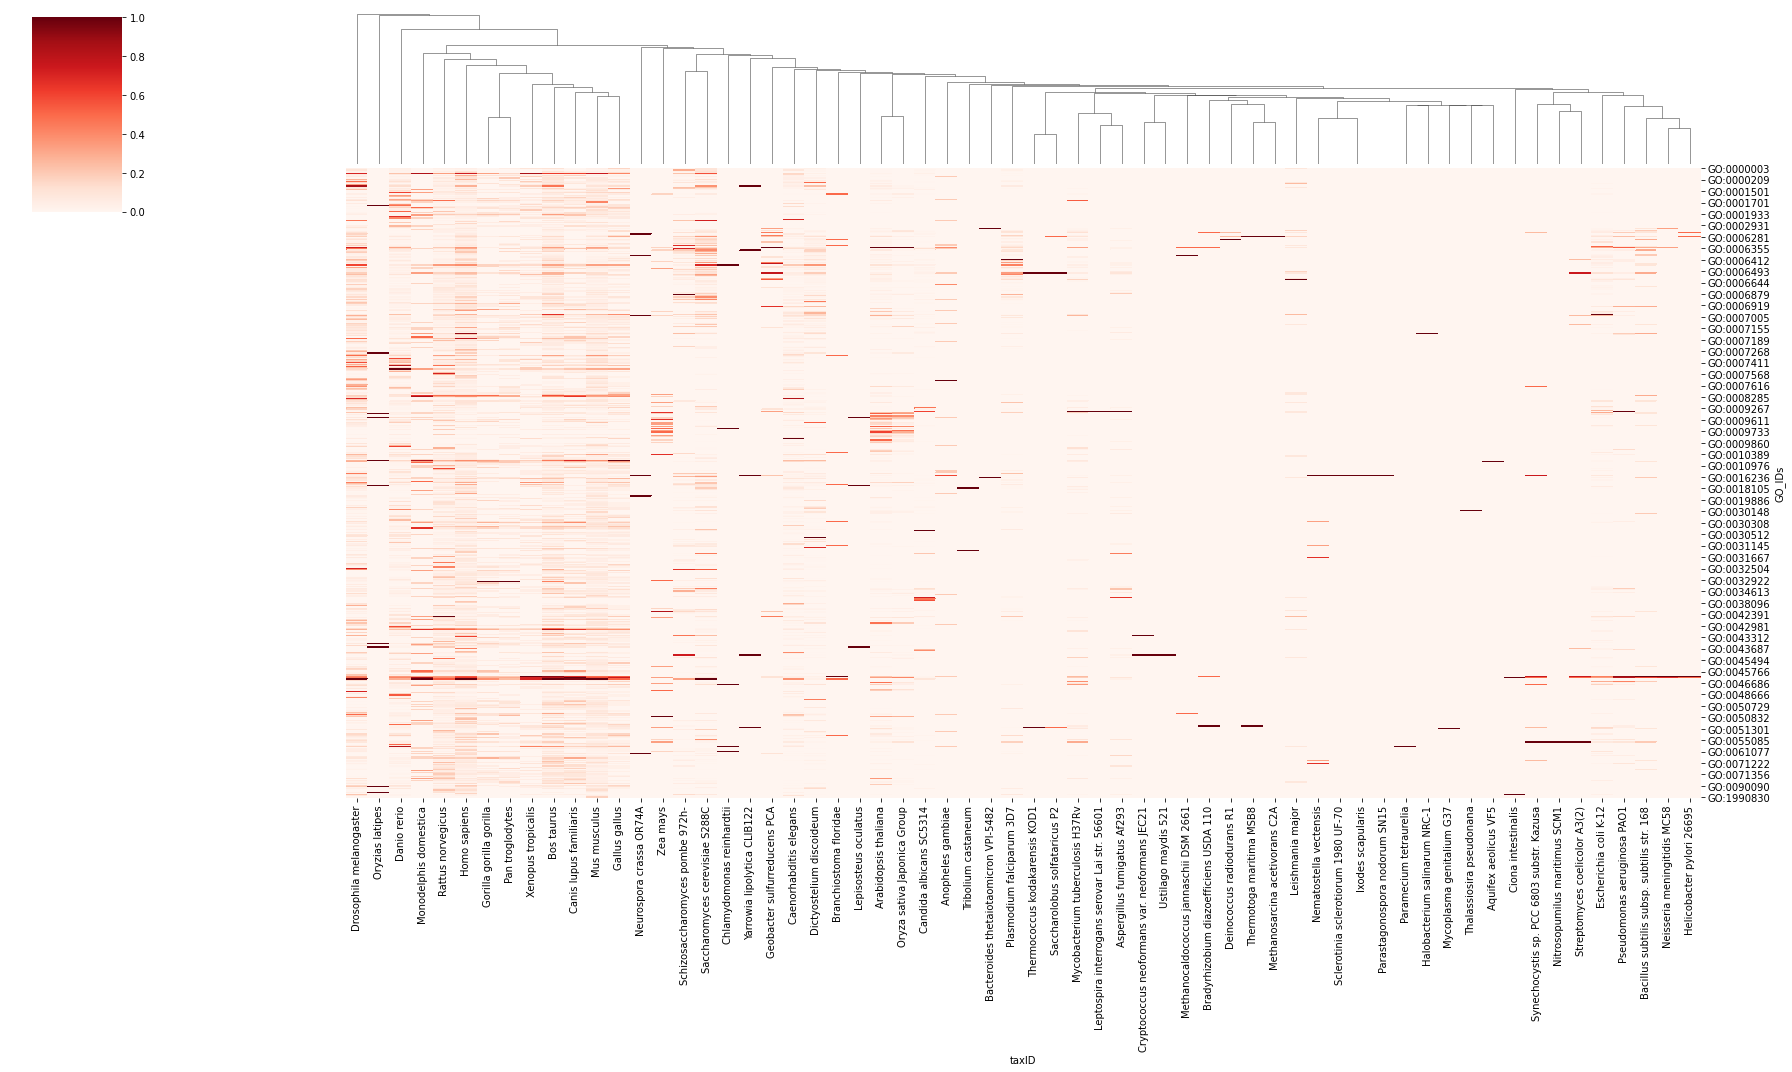

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plot = sns.clustermap(GO_terms_distribution, 
               #method='complete', metric='hamming', 
               standard_scale=1, figsize=(25, 15), 
               row_cluster=False, col_cluster=True, 
               cmap="Reds",        # Other way sns.mpl_palette("reds",n_colors=2, as_cmap=True))
               xticklabels=1
               )
plot

#### Interactive Heat Map

In [ ]:
# Scaling data with sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
scaler = MinMaxScaler()
GO_terms_distribution_scaled = pd.DataFrame(scaler.fit_transform(GO_terms_distribution.values), columns=GO_terms_distribution.columns, index=GO_terms_distribution.index)
GO_terms_distribution_scaled

taxID,Homo sapiens,Gorilla gorilla gorilla,Pan troglodytes,Mus musculus,Rattus norvegicus,Canis lupus familiaris,Bos taurus,Monodelphis domestica,Gallus gallus,Xenopus tropicalis,Ciona intestinalis,Branchiostoma floridae,Lepisosteus oculatus,Danio rerio,Oryzias latipes,Helobdella robusta,Nematostella vectensis,Caenorhabditis elegans,Monosiga brevicollis,Leishmania major,Ixodes scapularis,Dictyostelium discoideum,Batrachochytrium dendrobatidis JAM81,Chlamydomonas reinhardtii,Trichomonas vaginalis,Tribolium castaneum,Giardia lamblia ATCC 50803,Physcomitrium patens,Paramecium tetraurelia,Anopheles gambiae,Drosophila melanogaster,Thalassiosira pseudonana,Plasmodium falciparum 3D7,Phytophthora ramorum,Leptospira interrogans serovar Lai str. 56601,Fusobacterium nucleatum subsp. nucleatum ATCC 25586,Cryptococcus neoformans var. neoformans JEC21,Aquifex aeolicus VF5,Bacteroides thetaiotaomicron VPI-5482,Ustilago maydis 521,Thermotoga maritima MSB8,Schizosaccharomyces pombe 972h-,Thermodesulfovibrio yellowstonii DSM 11347,Puccinia graminis f. sp. tritici CRL 75-36-700-3,Dictyoglomus turgidum DSM 6724,Arabidopsis thaliana,Thermococcus kodakarensis KOD1,Neisseria meningitidis MC58,Bacillus subtilis subsp. subtilis str. 168,Bradyrhizobium diazoefficiens USDA 110,Rhodopirellula baltica SH 1,Deinococcus radiodurans R1,Methanocaldococcus jannaschii DSM 2661,Mycoplasma genitalium G37,Chlamydia trachomatis D/UW-3/CX,Saccharolobus solfataricus P2,Chloroflexus aurantiacus J-10-fl,Candidatus Korarchaeum cryptofilum OPF8,Nitrosopumilus maritimus SCM1,Zea mays,Oryza sativa Japonica Group,Halobacterium salinarum NRC-1,Mycobacterium tuberculosis H37Rv,Escherichia coli K-12,Helicobacter pylori 26695,Streptomyces coelicolor A3(2),Methanosarcina acetivorans C2A,Pseudomonas aeruginosa PAO1,Candida albicans SC5314,Geobacter sulfurreducens PCA,Gloeobacter violaceus PCC 7421,Yarrowia lipolytica CLIB122,Parastagonospora nodorum SN15,Aspergillus fumigatus Af293,Saccharomyces cerevisiae S288C,Synechocystis sp. PCC 6803 substr. Kazusa,Neurospora crassa OR74A,Sclerotinia sclerotiorum 1980 UF-70
GO_IDs,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
GO:0000003,0.001325,0.0,0.00,0.001364,0.004706,0.000000,0.000000,0.0,0.032258,0.000000,0.0,0.0,0.0,0.006452,0.0,0.0,0.0,0.347826,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005051,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.008576,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0
GO:0000045,0.039735,0.0,0.05,0.042292,0.030588,0.000000,0.112903,0.0,0.161290,0.095238,0.0,0.0,0.0,0.032258,0.0,0.0,0.0,0.018116,0.0,0.083333,0.0,0.03125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.035354,0.0,0.010989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008621,0.0,0.0,0.0,0.003431,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.102857,0.0,0.0,0.0
GO:0000070,0.021192,0.0,0.00,0.016371,0.011765,0.000000,0.016129,0.0,0.032258,0.000000,0.0,0.0,0.0,0.025806,0.0,0.0,0.0,0.083333,0.0,0.000000,0.0,0.01250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.101010,0.0,0.032967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.293103,0.0,0.0,0.0,0.006861,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.013624,0.0,0.0,0.0,0.0,0.00000,0.102857,0.0,0.0,0.0
GO:0000082,0.103311,0.0,0.00,0.046385,0.040000,0.043478,0.096774,0.0,0.032258,0.000000,0.0,0.0,0.0,0.019355,0.0,0.0,0.0,0.007246,0.0,0.000000,0.0,0.01250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.035354,0.0,0.010989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.034483,0.0,0.0,0.0,0.005146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.010899,0.0,0.0,0.0,0.0,0.00000,0.125714,0.0,0.0,0.0
GO:0000086,0.154967,0.0,0.00,0.032742,0.023529,0.086957,0.080645,0.0,0.129032,0.000000,0.0,0.0,0.0,0.019355,0.0,0.0,0.0,0.000000,0.

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Heatmap(
                   z=GO_terms_distribution_scaled.values,
                   x=GO_terms_distribution_scaled.columns,
                   y=GO_terms_distribution_scaled.index,
                   hoverongaps = False,
                   colorscale='Reds',
                   colorbar= dict(title="Intensity")
                   ))
fig.update_layout(
    title='Go terms distribution',
)
fig.update_yaxes(title="GO terms")
fig.update_xaxes(type='category', title="Species")
fig.show()


# Validating ML approach

Make predictions on a curated dataset for a certain function that its know to have a high phylogenetic signal. The relationships between the proteins should be high and thus, the model should be able to effectively learn from it. 

This is done as a proof of concept -> Does the Phylogenetic Profiles really provide information to the ML models?


### Using only mitocondria annotated proteins

In [2]:
# From MitoCarta v3 dataset (https://academic.oup.com/nar/article/44/D1/D1251/2502576#81915924)
with open("/content/drive/MyDrive/TFG/human_mitocarta_v3.txt", "r") as input:
    mitocarta = set(input.read().splitlines())
len(mitocarta)

1132

In [ ]:
# From the QuickGO web interface, by manually filtering by 9606 specie, Cellular Component GO Aspect, the respective experimental Evidence Codes and GO:0005739 (only "is_a" relationships)
mito_dataset_quickgo = pd.read_csv("/content/drive/MyDrive/TFG/QuickGO-annotations-C_aspect-GO0005739.tsv", sep="\t", header=0)
mito_proteins_quickgo = set(mito_dataset_quickgo["GENE PRODUCT ID"].tolist())
len(mito_proteins_quickgo)

1599

In [ ]:
# Datasets comparison
len(mitocarta.intersection(mito_proteins_quickgo))

661

In [3]:
mitoproteins = mitocarta #| mito_proteins_quickgo # Sets union
len(mitoproteins)

1132

In [ ]:
mitoproteins = set(profiling_matrix.explode("GO_IDs")[profiling_matrix.explode("GO_IDs")["GO_IDs"]=="GO:0044238"].index.get_level_values(1))

#### Prepare training dataset

In [17]:
# Retrieve human Phylogenetic Matrix without GO terms
human_pp_matrix = profiling_matrix.drop(columns=["9606", "GO_IDs"], axis=1, errors='ignore') # .loc[9606] if all the matrix
human_pp_matrix

,189518,85962,208964,122586,83333,272561,226186,190304,324602,1111708,243230,224308,83332,100226,243273,243232,188937,64091,273057,243274,3055,3218,3702,39947,4577,284812,559292,284591,367110,665079,214684,237631,418459,237561,5664,5722,184922,36329,5888,6239,6412,6945,7070,7165,7227,7719,7739,7955,8090,8364,9031,9595,9598,9615,9913,10090,10116,13616,321614,289376,251221,35128,243231,44689,45351,224324,81824,684364,164328,243090,69014,436308,374847,515635,330879,224911,7918
Q96T66,1,0,1,0,1,0,1,1,1,1,0,1,1,1,0,0,0,0,0,1,1,4,0,0,1,1,2,1,1,1,0,1,1,1,1,2,0,0,0,0,1,1,1,2,1,0,1,1,0,0,0,1,1,1,1,1,0,1,1,1,1,0,1,1,1,1,1,0,1,1,0,0,0,1,1,0,0
Q6IQ20,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,1,0,0,0,0,0,1,1,1,1,0,4,0,1,0,0,0,1,0,2,0,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,2,3,0,0,0,0,0,0,0,0,0,3,0,0
Q9H3J6,2,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,1,0,1,0,0,0,1,1,1,1,0,1,1,1,0,1,0,1,0,1,1,1,1,1,1,1,0,1,2,1,0,2,0,1,0,0,1,1,0,0,0,0,0,1,0,0
Q14397,1,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,1,1,0,1,1,1,0,1,1,0,1,1,1,1,2,0,0,0,0,0,0,0,0,0,0
Q8NFV4,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,1,1,0,1,1,1,1,1,0,1,0,2,1,1,0,1,0,2,1,1,1,0,2,1,1,1,1,0,1,1,1,1,1,1,1,3,1,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A6NED7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0
M0R036,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
O14598,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
Q5T7P6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [18]:
# Add label column
human_pp_matrix["isMitochondrial"] = human_pp_matrix.index.map(lambda x: 1 if x in mitoproteins else 0)
human_pp_matrix

,189518,85962,208964,122586,83333,272561,226186,190304,324602,1111708,243230,224308,83332,100226,243273,243232,188937,64091,273057,243274,3055,3218,3702,39947,4577,284812,559292,284591,367110,665079,214684,237631,418459,237561,5664,5722,184922,36329,5888,6239,6412,6945,7070,7165,7227,7719,7739,7955,8090,8364,9031,9595,9598,9615,9913,10090,10116,13616,321614,289376,251221,35128,243231,44689,45351,224324,81824,684364,164328,243090,69014,436308,374847,515635,330879,224911,7918,isMitochondrial
Q96T66,1,0,1,0,1,0,1,1,1,1,0,1,1,1,0,0,0,0,0,1,1,4,0,0,1,1,2,1,1,1,0,1,1,1,1,2,0,0,0,0,1,1,1,2,1,0,1,1,0,0,0,1,1,1,1,1,0,1,1,1,1,0,1,1,1,1,1,0,1,1,0,0,0,1,1,0,0,1
Q6IQ20,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,1,0,0,0,0,0,1,1,1,1,0,4,0,1,0,0,0,1,0,2,0,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,2,3,0,0,0,0,0,0,0,0,0,3,0,0,0
Q9H3J6,2,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,1,0,1,0,0,0,1,1,1,1,0,1,1,1,0,1,0,1,0,1,1,1,1,1,1,1,0,1,2,1,0,2,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1
Q14397,1,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,1,1,0,1,1,1,0,1,1,0,1,1,1,1,2,0,0,0,0,0,0,0,0,0,0,0
Q8NFV4,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,1,1,0,1,1,1,1,1,0,1,0,2,1,1,0,1,0,2,1,1,1,0,2,1,1,1,1,0,1,1,1,1,1,1,1,3,1,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,2,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A6NED7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0
M0R036,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
O14598,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
Q5T7P6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [19]:
# Differentiate positive and negative samples
positive_samples = human_pp_matrix[human_pp_matrix["isMitochondrial"]==1]
negative_samples = human_pp_matrix[human_pp_matrix["isMitochondrial"]==0]
positive_samples

,189518,85962,208964,122586,83333,272561,226186,190304,324602,1111708,243230,224308,83332,100226,243273,243232,188937,64091,273057,243274,3055,3218,3702,39947,4577,284812,559292,284591,367110,665079,214684,237631,418459,237561,5664,5722,184922,36329,5888,6239,6412,6945,7070,7165,7227,7719,7739,7955,8090,8364,9031,9595,9598,9615,9913,10090,10116,13616,321614,289376,251221,35128,243231,44689,45351,224324,81824,684364,164328,243090,69014,436308,374847,515635,330879,224911,7918,isMitochondrial
Q96T66,1,0,1,0,1,0,1,1,1,1,0,1,1,1,0,0,0,0,0,1,1,4,0,0,1,1,2,1,1,1,0,1,1,1,1,2,0,0,0,0,1,1,1,2,1,0,1,1,0,0,0,1,1,1,1,1,0,1,1,1,1,0,1,1,1,1,1,0,1,1,0,0,0,1,1,0,0,1
Q9H3J6,2,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,1,0,1,0,0,0,1,1,1,1,0,1,1,1,0,1,0,1,0,1,1,1,1,1,1,1,0,1,2,1,0,2,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1
Q8NFV4,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,1,1,0,1,1,1,1,1,0,1,0,2,1,1,0,1,0,2,1,1,1,0,2,1,1,1,1,0,1,1,1,1,1,1,1,3,1,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,2,0,0,1
O76031,1,1,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,3,3,4,3,0,1,1,1,1,0,1,0,1,0,0,0,0,0,2,1,1,1,1,1,1,1,2,0,0,1,0,1,1,1,1,1,1,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1
P22234,2,0,1,0,2,0,0,1,1,0,0,1,2,0,0,0,0,0,1,1,0,0,0,0,0,1,1,1,1,0,0,1,0,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,2,1,1,0,0,1,3,1,1,0,1,0,0,0,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q8N4H5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
Q8TDB4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
Q9C002,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
A8MSI8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [20]:
# Build training dataset from a combination of the positive and the same number of randomly negative samples.
import numpy as np

negative_samples_subset = np.random.choice(negative_samples.index, size=positive_samples.shape[0])
training_samples = np.concatenate([negative_samples_subset,positive_samples.index])
training_matrix = human_pp_matrix.loc[training_samples, :]
training_matrix = training_matrix.sample(frac=1) # shuffle samples to avoid biase when splitting into train and test sets
training_matrix

,189518,85962,208964,122586,83333,272561,226186,190304,324602,1111708,243230,224308,83332,100226,243273,243232,188937,64091,273057,243274,3055,3218,3702,39947,4577,284812,559292,284591,367110,665079,214684,237631,418459,237561,5664,5722,184922,36329,5888,6239,6412,6945,7070,7165,7227,7719,7739,7955,8090,8364,9031,9595,9598,9615,9913,10090,10116,13616,321614,289376,251221,35128,243231,44689,45351,224324,81824,684364,164328,243090,69014,436308,374847,515635,330879,224911,7918,isMitochondrial
O95858,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,1,1,1,1,1,1,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
Q96BH1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,1,1,1,1,0,0,1,1,2,1,1,1,1,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0
Q8WVP5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,1,1,0,0,1,0,1,1,1,1,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
O43865,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,2,0,1,1,1,1,1,1,1,1,0,1,1,1,1,0,1,1,0,0,0,0,1,1,1,1,0,0,0,1
Q9Y243,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,2,3,0,0,0,0,0,0,0,0,0,0,7,0,0,1,3,1,1,1,1,0,0,0,2,2,0,0,1,1,1,1,1,1,1,0,0,0,0,0,1,1,0,2,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q15546,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,1,1,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
Q9Y3B1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,2,2,1,2,1,1,1,1,1,0,1,0,0,0,1,0,1,1,1,1,1,1,1,1,1,2,0,1,1,1,1,0,1,1,1,1,0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,1,0,0,1
Q8WUI4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
P03915,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,1,1,1,1,1,1,0,0,1,0,0,0,1,1,2,0,0,0,0,0,0,1,0,0,0,0,1


In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split

X_training_matrix = training_matrix.iloc[:, :-1]
y_training_matrix = training_matrix.iloc[:, -1] # last column corresponds to "isMitochondrial" column

X_train, X_test, y_train, y_test = train_test_split(X_training_matrix, y_training_matrix, test_size=0.20)
X_train

,189518,85962,208964,122586,83333,272561,226186,190304,324602,1111708,243230,224308,83332,100226,243273,243232,188937,64091,273057,243274,3055,3218,3702,39947,4577,284812,559292,284591,367110,665079,214684,237631,418459,237561,5664,5722,184922,36329,5888,6239,6412,6945,7070,7165,7227,7719,7739,7955,8090,8364,9031,9595,9598,9615,9913,10090,10116,13616,321614,289376,251221,35128,243231,44689,45351,224324,81824,684364,164328,243090,69014,436308,374847,515635,330879,224911,7918
Q14684,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,1,2,1,1,1,1,1,0,1,0,1,1,1,0,0,1,1,1,0,1,1,1,1,1,0,1,0,0,1,1,1,1,1,1,1,1,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0
Q9BV99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,1,0,0,1,1,1,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0
A2RUR9,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,3,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,3,0,1,0,0,1,0,0,0,0,0,0,0
Q96CT7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,2,1,1,1,1,1,1,1,1,0,1,1,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,0,1,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0
Q9NVH0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,0,0,0,0,2,2,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q07820,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,1,0,1,1,1,0,2,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
Q8N490,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,1,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
Q16775,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,1,0,2,2,1,1,1,0,1,0,1,0,1,0,0,0,1,1,1,1,1,1,0,1,1,1,0,1,1,0,1,1,1,1,1,1,0,0,1,0,1,2,0,2,0,1,0,0,0,0,0,1,0,0
A8MUP2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,1,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0


#### Model selection

In [9]:
# Support multilabel by default
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# Does not support multilabel but multiclass does
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
#from sklearn.linear_model import RidgeClassifierCV
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LinearRegression

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate

#### Model training

In [ ]:
# With cross-validation
model = RandomForestClassifier(random_state=0)
pd.DataFrame(cross_validate(model, X_training_matrix, y_training_matrix, cv=5, scoring=("accuracy", "f1", "roc_auc"), n_jobs=-1)).mean()

fit_time         0.531004
score_time       0.065661
test_accuracy    0.755780
test_f1          0.755645
test_roc_auc     0.829443
dtype: float64

In [10]:
# Simple method (without cross-validation)
model = RandomForestClassifier(random_state=0).fit(X_train, y_train) # Defaults parameters of RF: n_estimators=100, criterion="gini", max_features="sqrt"
y_test_predictions = model.predict(X_test)
accuracy_score(y_test, y_test_predictions)

0.7592592592592593

#### ROC curve

Credits: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

"Model" should be already fit

###### Manual way

In [ ]:
# Predict probabilities 
from sklearn.metrics import roc_auc_score

mit_probs = model.predict_proba(X_test)[:,1] # Only for the positive outcome (Mitochondrial in this case)
mit_auc = roc_auc_score(y_test, mit_probs)
mit_auc

0.8303535061204362

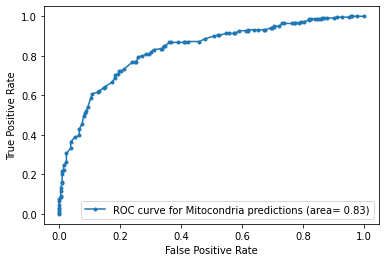

In [ ]:
# PLOT ROC CURVE

from sklearn.metrics import roc_curve
from matplotlib import pyplot

# Calculate False Negative and True Positive Rates
mit_fpr, mit_tpr, _ = roc_curve(y_test, mit_probs)

# plot the roc curve for the model
pyplot.plot(mit_fpr, mit_tpr, marker='.', label='ROC curve for Mitocondria predictions (area= %0.2f)' % mit_auc)

pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

###### Simple way

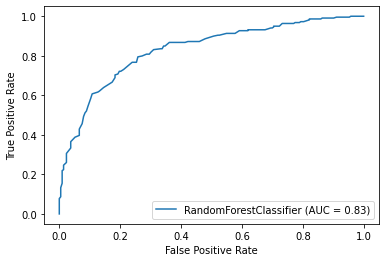

In [ ]:
from matplotlib import pyplot
from sklearn.metrics import plot_roc_curve

plot_roc_curve(model, X_test, y_test)
pyplot.show()

###### ROC Curve comparison of different models

In [22]:
# Predict probabilities for the models we are interested in compare
ns_probs = [0] * len(y_test) # generate a no skill prediction (majority class)
probs1 = DummyClassifier(random_state=0, strategy='prior').fit(X_train, y_train).predict_proba(X_test)[:,1] 
probs2 = GradientBoostingClassifier(random_state=0).fit(X_train, y_train).predict_proba(X_test)[:,1] 
probs3 = KNeighborsClassifier().fit(X_train, y_train).predict_proba(X_test)[:,1]
probs4 = MultinomialNB().fit(X_train, y_train).predict_proba(X_test)[:,1] 
probs5 = MLPClassifier(random_state=0).fit(X_train, y_train).predict_proba(X_test)[:,1] 
probs6 = RandomForestClassifier(random_state=0).fit(X_train, y_train).predict_proba(X_test)[:,1] 
probs7 = SVC(random_state=0, probability=True).fit(X_train, y_train).predict_proba(X_test)[:,1] 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [23]:
# CALCULATE AUC SCORE

from sklearn.metrics import roc_auc_score

ns_auc = roc_auc_score(y_test, ns_probs)
auc1 = roc_auc_score(y_test, probs1)
auc2 = roc_auc_score(y_test, probs2)
auc3 = roc_auc_score(y_test, probs3)
auc4 = roc_auc_score(y_test, probs4)
auc5 = roc_auc_score(y_test, probs5)
auc6 = roc_auc_score(y_test, probs6)
auc7 = roc_auc_score(y_test, probs7)

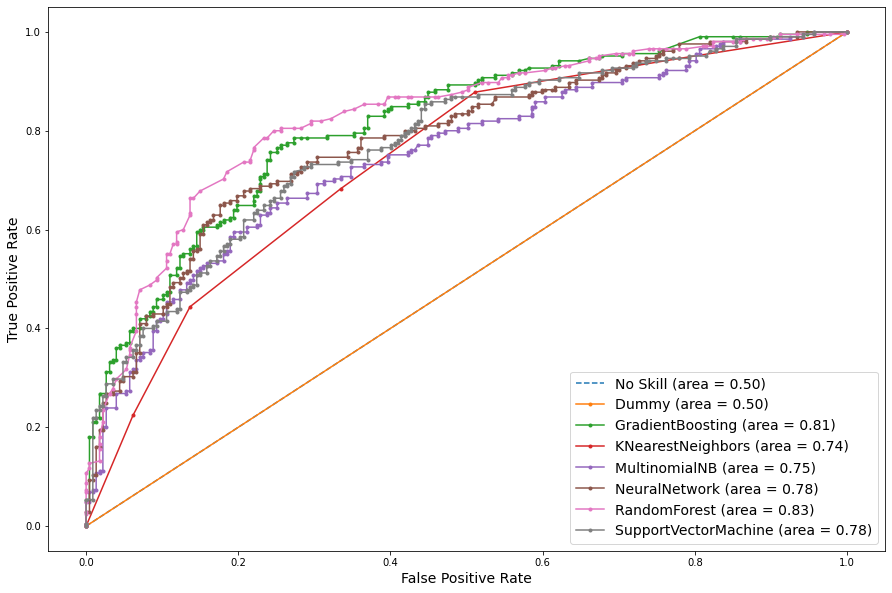

In [29]:
# PLOT ROC CURVE

from sklearn.metrics import roc_curve
from matplotlib import pyplot

# Calculate False Negative and True Positive Rates
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
fpr1, tpr1, _ = roc_curve(y_test, probs1)
fpr2, tpr2, _ = roc_curve(y_test, probs2)
fpr3, tpr3, _ = roc_curve(y_test, probs3)
fpr4, tpr4, _ = roc_curve(y_test, probs4)
fpr5, tpr5, _ = roc_curve(y_test, probs5)
fpr6, tpr6, _ = roc_curve(y_test, probs6)
fpr7, tpr7, _ = roc_curve(y_test, probs7)

pyplot.figure(figsize=(15, 10))

# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill (area = %0.2f)' % ns_auc)
pyplot.plot(fpr1, tpr1, marker='.', label='Dummy (area = %0.2f)' % auc1)
pyplot.plot(fpr2, tpr2, marker='.', label='GradientBoosting (area = %0.2f)' % auc2)
pyplot.plot(fpr3, tpr3, marker='.', label='KNearestNeighbors (area = %0.2f)' % auc3)
pyplot.plot(fpr4, tpr4, marker='.', label='MultinomialNB (area = %0.2f)' % auc4)
pyplot.plot(fpr5, tpr5, marker='.', label='NeuralNetwork (area = %0.2f)' % auc5)
pyplot.plot(fpr6, tpr6, marker='.', label='RandomForest (area = %0.2f)' % auc6)
pyplot.plot(fpr7, tpr7, marker='.', label='SupportVectorMachine (area = %0.2f)' % auc7)

pyplot.xlabel('False Positive Rate', fontsize=14)
pyplot.ylabel('True Positive Rate', fontsize=14)
pyplot.legend(loc="lower right", prop={"size": 14})
pyplot.show()


#### Parameter optimization

This section was done after selecting Random Forest as best candidate classifier

Tutorial on https://towardsdatascience.com/gridsearchcv-for-beginners-db48a90114ee 

###### GridSearch

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "criterion": ["gini", "entropy"],
    "n_estimators": [100, 300, 500],
    "max_features": ["sqrt", "log2"]
}

gs_random_forest = GridSearchCV(RandomForestClassifier(random_state=1), param_grid=param_grid, scoring="f1", cv=5, n_jobs=1)
gs_random_forest.fit(X_training_matrix, y_training_matrix)
gs_random_forest.best_params_

{'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 300}

In [ ]:
pd.DataFrame(gs_random_forest.cv_results_).sort_values("rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
10,1.027796,0.009711,0.063134,0.001852,entropy,log2,300,"{'criterion': 'entropy', 'max_features': 'log2...",0.788288,0.767442,0.764977,0.752887,0.762791,0.767277,0.011610,1
8,1.845614,0.014050,0.104899,0.003869,entropy,sqrt,500,"{'criterion': 'entropy', 'max_features': 'sqrt...",0.798186,0.781176,0.755245,0.752294,0.748837,0.767148,0.019276,2
1,0.992193,0.014914,0.065887,0.002640,gini,sqrt,300,"{'criterion': 'gini', 'max_features': 'sqrt', ...",0.786517,0.766667,0.778802,0.754023,0.744186,0.766039,0.015521,3
2,1.644224,0.015587,0.101573,0.001632,gini,sqrt,500,"{'criterion': 'gini', 'max_features': 'sqrt', ...",0.796421,0.759434,0.774942,0.754023,0.745370,0.766038,0.017986,4
5,1.545238,0.037216,0.105448,0.002824,gini,log2,500,"{'criterion': 'gini', 'max_features': 'log2', ...",0.781038,0.766355,0.769585,0.755149,0.751740,0.764774,0.010514,5
11,1.717259,0.015403,0.106714,0.001763,entropy,log2,500,"{'criterion': 'entropy', 'max_features': 'log2...",0.796421,0.759907,0.759907,0.749425,0.757506,0.764633,0.016354,6
7,1.112863,0.012607,0.063497,0.001226,entropy,sqrt,300,"{'criterion': 'entropy', 'max_features': 'sqrt...",0.793651,0.766667,0.763889,0.748268,0.750000,0.764495,0.016301,7
4,0.932830,0.010750,0.066732,0.004665,gini,log2,300,"{'criterion': 'gini', 'max_features': 'log2', ...",0.791011,0.756501,0.775982,0.744292,0.751740,0.763905,0.017135,8
6,0.369718,0.006192,0.022247,0.000058,entropy,sqrt,100,"{'criterion': 'entropy', 'max_features': 'sqrt...",0.795455,0.771429,0.766744,0.748837,0.733179,0.763129,0.021110,9
3,0.309754,0.005363,0.024161,0.001239,gini,log2,100,"{'criterion': 'gini', 'max_features': 'log2', ...",0.778032,0.767059,0.764569,0.752294,0.744828,0.761356,0.011630,10


###### Comparisong of Random Forest with different parameters

In [ ]:
# Predict probabilities for the models we are interested in compare
ns_probs = [0] * len(y_test) # generate a no skill prediction (majority class)
probs1 = RandomForestClassifier(random_state=0, n_estimators=300, criterion="entropy", max_features="log2").fit(X_train, y_train).predict_proba(X_test)[:,1] # Best performing parameters
probs2 = RandomForestClassifier(random_state=0, n_estimators=100, criterion="gini", max_features="log2").fit(X_train, y_train).predict_proba(X_test)[:,1] # Worst performing paremeters
probs3 = RandomForestClassifier(random_state=0, n_estimators=100, criterion="gini", max_features="sqrt").fit(X_train, y_train).predict_proba(X_test)[:,1] #Default parameters

In [ ]:
# CALCULATE AUC SCORE

from sklearn.metrics import roc_auc_score

ns_auc = roc_auc_score(y_test, ns_probs)
auc1 = roc_auc_score(y_test, probs1)
auc2 = roc_auc_score(y_test, probs2)
auc3 = roc_auc_score(y_test, probs3)

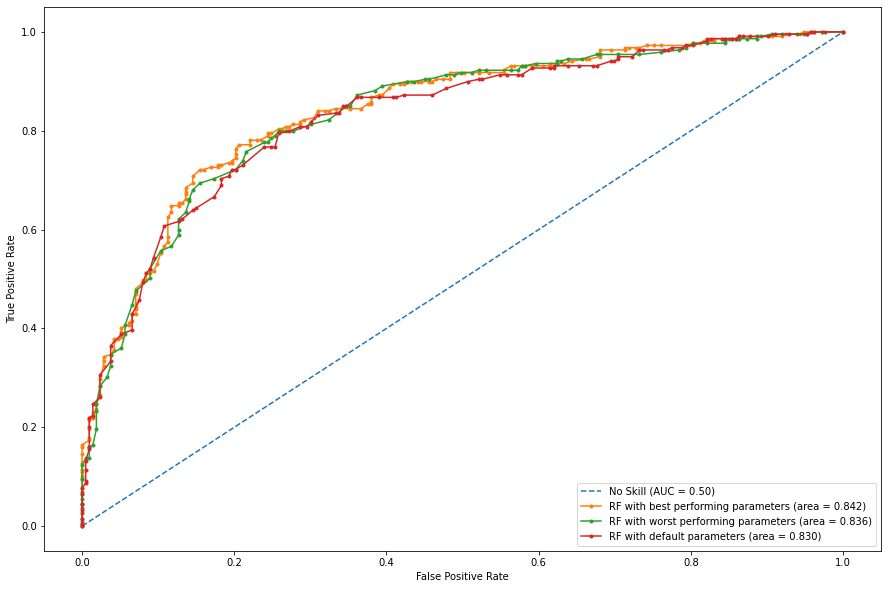

In [ ]:
# PLOT ROC CURVE

from sklearn.metrics import roc_curve
from matplotlib import pyplot

# Calculate False Negative and True Positive Rates
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
fpr1, tpr1, _ = roc_curve(y_test, probs1)
fpr2, tpr2, _ = roc_curve(y_test, probs2)
fpr3, tpr3, _ = roc_curve(y_test, probs3)

pyplot.figure(figsize=(15, 10))

# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill (AUC = %0.2f)' % ns_auc)
pyplot.plot(fpr1, tpr1, marker='.', label='RF with best performing parameters (area = %0.3f)' % auc1)
pyplot.plot(fpr2, tpr2, marker='.', label='RF with worst performing parameters (area = %0.3f)' % auc2)
pyplot.plot(fpr3, tpr3, marker='.', label='RF with default parameters (area = %0.3f)' % auc3)

pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend(loc="lower right")
pyplot.show()


# Model selection

In [ ]:
# Support multilabel by default
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# Does not support multilabel but multiclass does
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
#from sklearn.linear_model import RidgeClassifierCV
from sklearn.naive_bayes import MultinomialNB

from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate


In [ ]:
# From https://towardsdatascience.com/simple-way-to-find-a-suitable-algorithm-for-your-data-in-scikit-learn-python-9a9710c7c0fe

def create_baseline_classifiers(seed=8):
    """Create a list of baseline classifiers.
    
    Parameters
    ----------
    seed: (optional) An integer to set seed for reproducibility
    Returns
    -------
    A list containing tuple of model's name and object.
    """
    models = {}
    # Inherently multilabel
    models['Dummy'] = DummyClassifier(random_state=seed, strategy='prior')
    models['RandomForest'] = RandomForestClassifier(random_state=seed, n_jobs=1) # Random Forest consumes a lot of memory to be run in parallel
    models['KNN'] = KNeighborsClassifier(n_jobs=1)
    models['NeuralNetwork'] = MLPClassifier(random_state=seed)

    # No support for multilabel unless using OneVSRestClassifier or ClassifierChain
    models['SupportVectorMachine'] = OneVsRestClassifier(SVC(random_state=seed, probability=True), n_jobs=1)
    models['GradientBoosting'] = OneVsRestClassifier(GradientBoostingClassifier(random_state=seed), n_jobs=1)
    models['MultinomialNB'] = OneVsRestClassifier(MultinomialNB(), n_jobs=1)
    return models

def assess_models(X, y, models, cv=5, metrics=('accuracy','roc_auc', 'f1')):
    """Provide summary of cross validation results for models.
    
    Parameters
    ----------
    X: A pandas DataFrame containing feature matrix
    y: A pandas Series containing target vector
    models: A list of models to train
    cv: (optional) An integer to set number of folds in cross-validation
    metrics: (optional) A list of scoring metrics or a string for a metric
    Returns
    -------
    A pandas DataFrame containing summary of baseline models' performance.
    
    """
    summary = pd.DataFrame()
    for name, model in models.items():
        result = pd.DataFrame(cross_validate(model, X, y, cv=cv, scoring=metrics, n_jobs=-1))
        mean = result.mean().rename('{}_mean'.format)
        std = result.std().rename('{}_std'.format)
        summary[name] = pd.concat([mean, std], axis=0)
    return summary.sort_index()

## APPROACH 1: Multilabel (multiple GO terms) classification models

### Prepare training dataset

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

training_matrix = profiling_matrix[profiling_matrix["GO_IDs"].str.len()>0]  # Filter out some proteins that may have remained without any annotation after passing through the ocurrences filter.

X_training_matrix = training_matrix.iloc[:, :-1]
y_training_matrix = training_matrix.iloc[:, -1:] # The last column corresponds to the GO_IDs

# We need to compute one-hot encoding for multilable classification as the models does not accept matrices with different shape.
mlb = MultiLabelBinarizer()
y_training_matrix_encoded = pd.DataFrame(mlb.fit_transform(y_training_matrix["GO_IDs"]), columns=mlb.classes_, index=y_training_matrix.index)

y_training_matrix_encoded = y_training_matrix_encoded[["GO:0005739"]]
y_training_matrix_encoded

GO:0005739
9606   Q96T66           1
       Q6IQ20           0
       Q9H3J6           1
       Q14397           0
       O76031           1
...                   ...
243274 Q9X256           0
       Q9X0Y7           0
       Q9X2I1           0
       Q9X1Z1           0
       Q9X1G6           0

[69440 rows x 1 columns]

### Models training

In [ ]:
# Train one model without cross-validation
X_train, X_test, y_train, y_test = train_test_split(X_training_matrix, y_training_matrix_encoded, test_size=0.25)
model = RandomForestClassifier().fit(X_train, y_train)
y_test_predictions = model.predict(X_test)
accuracy_score(y_test, y_test_predictions)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


0.9229262672811059

In [ ]:
# Train one model With cross-validation
model = RandomForestClassifier()
cross_validate(model, X_train, y_train, cv=5, scoring=("accuracy", "roc_auc", "f1_micro", "recall", "precision"), n_jobs=1) # We could also choose only one scoring method

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 

{'fit_time': array([7.49895883, 7.7505722 , 7.80583286, 7.73796582, 7.89953637]),
 'score_time': array([0.6406827 , 0.65980291, 0.65858722, 0.71561956, 0.71339822]),
 'test_accuracy': array([0.91935484, 0.91973886, 0.92242704, 0.91906682, 0.92233103]),
 'test_f1_micro': array([0.91935484, 0.91973886, 0.92242704, 0.91906682, 0.92233103]),
 'test_precision': array([0.65145228, 0.65853659, 0.71544715, 0.66063348, 0.70916335]),
 'test_recall': array([0.17196057, 0.17724289, 0.19256018, 0.15973742, 0.19474836]),
 'test_roc_auc': array([0.8081183 , 0.79820291, 0.81609987, 0.80807922, 0.80715962])}

In [ ]:
# Train several models
models = create_baseline_classifiers()
summary = assess_models(X_train, y_train, models, metrics=("accuracy", "f1_macro"))
summary

,Dummy,RandomForest,KNN,NeuralNetwork,SupportVectorMachine,GradientBoosting,MultinomialNB
fit_time_mean,0.012070,6.066271,0.049460,9.410647,218.109081,59.386899,0.332783
fit_time_std,0.000399,0.467689,0.000491,1.205765,26.750227,3.315319,0.034970
score_time_mean,0.011875,0.613065,2.749094,0.017109,6.199454,0.256870,0.180541
score_time_std,0.000880,0.055037,0.228358,0.001353,0.242055,0.018800,0.013614
test_accuracy_mean,0.000000,0.032314,0.038468,0.033168,0.012139,0.035391,0.008206
test_accuracy_std,0.000000,0.002299,0.003578,0.007314,0.003795,0.003504,0.002057
test_f1_macro_mean,0.000000,0.106273,0.106140,0.112676,0.022425,0.131963,0.096278
test_f1_macro_std,0.000000,0.014950,0.014010,0.011316,0.003732,0.007767,0.004421


In [ ]:
summary.to_csv("results/MTP/MtP_201601_blasted-ML_asessment.tab")

### Model evaluation

In [ ]:
predictions = pd.DataFrame(y_test_predictions, columns=y_test.columns, index=y_test.index)
predictions 

GO:0000226  GO:0001505  ...  GO:1901700  GO:1903047
9606 Q9UBD9           0           0  ...           0           0
     Q14166           0           0  ...           0           0
     O95249           0           0  ...           0           1
     Q92551           0           0  ...           0           0
     P50748           0           0  ...           0           0
...                 ...         ...  ...         ...         ...
     Q8N5Z5           0           0  ...           0           0
     P40763           0           0  ...           0           0
     P22102           0           0  ...           0           0
     P41161           0           0  ...           0           0
     Q969Z3           0           0  ...           0           0

[2912 rows x 208 columns]

In [ ]:
probabilities = model.predict_proba(X_test)
probabilities = pd.DataFrame(probabilities, columns=y_test.columns, index=y_test.index)
probabilities

GO:0000226  GO:0001505  ...  GO:1901700  GO:1903047
9606 Q9UBD9        0.00        0.00  ...        0.00        0.00
     Q14166        0.01        0.00  ...        0.00        0.10
     O95249        0.01        0.01  ...        0.00        0.58
     Q92551        0.01        0.00  ...        0.06        0.04
     P50748        0.01        0.00  ...        0.04        0.01
...                 ...         ...  ...         ...         ...
     Q8N5Z5        0.00        0.01  ...        0.01        0.05
     P40763        0.02        0.00  ...        0.11        0.00
     P22102        0.09        0.19  ...        0.24        0.12
     P41161        0.02        0.00  ...        0.11        0.04
     Q969Z3        0.01        0.03  ...        0.06        0.05

[2912 rows x 208 columns]

In [ ]:
probabilities.mean(axis=1).max()

0.20646634615384604

In [ ]:
set(zip(y_test.loc[9606, "Q9H222"], y_test.columns)) - set(zip(predictions.loc[9606, "Q9H222"], y_test.columns))

{(0, 'GO:0032940'),
 (0, 'GO:0044249'),
 (1, 'GO:0003008'),
 (1, 'GO:0032501'),
 (1, 'GO:0032879'),
 (1, 'GO:0042592'),
 (1, 'GO:0051239'),
 (1, 'GO:0055085')}

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test.loc[9606, "Q9H222"], predictions.loc[9606, "Q9H222"])

0.9615384615384616

## APPROACH 2: Multiple Binary classifiers

Uses same methodology as with mitocondria genes.
This approach gave better results that the multilabel approach

In [ ]:
# This following results were obtained from the pipeline (run in the MareNostrum4)

import pandas as pd

one_vs_all_assessment = pd.read_csv("drive/MyDrive/TFG/MtP_201601_blasted-include_go_parents-min_gos_100-max_gos_5000-ML_assessment-one_vs_rest.tab", sep="\t", header=[0,1], index_col=0)
one_vs_all_assessment

GO:0006139               ...       GO:1903034              
                        Dummy RandomForest  ... GradientBoosting MultinomialNB
fit_time_mean        0.001978     0.331655  ...         0.063144      0.003566
fit_time_std         0.000789     0.002730  ...         0.000777      0.000060
score_time_mean      0.003232     0.039189  ...         0.005069      0.004996
score_time_std       0.001461     0.000141  ...         0.000016      0.000050
test_accuracy_mean   0.520088     0.680652  ...         0.559768      0.592058
test_accuracy_std    0.003248     0.005246  ...         0.024299      0.047260
test_f1_macro_mean   0.342141     0.679809  ...         0.555712      0.575790
test_f1_macro_std    0.001406     0.005173  ...         0.025692      0.052928
test_roc_auc_mean    0.500000     0.738311  ...         0.598113      0.616450
test_roc_auc_std     0.000000     0.004475  ...         0.032839      0.038256

[10 rows x 6979 columns]

### Results analysis

In [ ]:
# How many GO terms
len(one_vs_all_assessment.columns.levels[0])

997

##### Best results

In [ ]:
# Best performing GO term/model
one_vs_all_assessment.idxmax(axis=1)

fit_time_mean         (GO:0048518, SupportVectorMachine)
fit_time_std          (GO:0016043, SupportVectorMachine)
score_time_mean                        (GO:0006807, KNN)
score_time_std        (GO:0016043, SupportVectorMachine)
test_accuracy_mean            (GO:0031424, RandomForest)
test_accuracy_std         (GO:0065004, GradientBoosting)
test_f1_macro_mean            (GO:0031424, RandomForest)
test_f1_macro_std     (GO:0050808, SupportVectorMachine)
test_roc_auc_mean            (GO:0031424, NeuralNetwork)
test_roc_auc_std          (GO:0065004, GradientBoosting)
dtype: object

In [ ]:
# Corresponding values of above best performing GO terms/model
one_vs_all_assessment.max(axis=1)

fit_time_mean         29.538313
fit_time_std           0.353294
score_time_mean        2.442197
score_time_std         0.113707
test_accuracy_mean     0.909987
test_accuracy_std      0.081198
test_f1_macro_mean     0.909828
test_f1_macro_std      0.085948
test_roc_auc_mean      0.966850
test_roc_auc_std       0.088918
dtype: float64

##### Worst results

In [ ]:
# Worst performing GO term/model
one_vs_all_assessment.idxmin(axis=1)

fit_time_mean                    (GO:0098657, Dummy)
fit_time_std                     (GO:0030001, Dummy)
score_time_mean                  (GO:0098657, Dummy)
score_time_std                   (GO:2001236, Dummy)
test_accuracy_mean       (GO:0043271, MultinomialNB)
test_accuracy_std                (GO:0007188, Dummy)
test_f1_macro_mean               (GO:0040029, Dummy)
test_f1_macro_std                (GO:0007188, Dummy)
test_roc_auc_mean     (GO:0097193, GradientBoosting)
test_roc_auc_std                 (GO:0006139, Dummy)
dtype: object

In [ ]:
# Corresponding values of above worst performing GO terms/model
one_vs_all_assessment.min(axis=1)

fit_time_mean         0.000703
fit_time_std          0.000003
score_time_mean       0.002019
score_time_std        0.000003
test_accuracy_mean    0.470709
test_accuracy_std     0.000000
test_f1_macro_mean    0.328525
test_f1_macro_std     0.000000
test_roc_auc_mean     0.453636
test_roc_auc_std      0.000000
dtype: float64

##### Mean results (for each model)

In [ ]:
# Mean results
# %load_ext google.colab.data_table # %unload_ext google.colab.data_table to unload
swaped_results = one_vs_all_assessment.swaplevel(axis=1)
swaped_results.mean(axis=1, level=0)

,Dummy,RandomForest,KNN,NeuralNetwork,SupportVectorMachine,GradientBoosting,MultinomialNB
fit_time_mean,0.000867,0.154288,0.005600,0.720761,0.905257,0.146390,0.003901
fit_time_std,0.000039,0.001573,0.000180,0.005073,0.008994,0.001397,0.000105
score_time_mean,0.002150,0.021954,0.082909,0.005270,0.070699,0.005485,0.005137
score_time_std,0.000056,0.000282,0.001141,0.000066,0.000976,0.000070,0.000091
test_accuracy_mean,0.503207,0.616134,0.579263,0.596403,0.599325,0.606504,0.586492
test_accuracy_std,0.002221,0.020348,0.019796,0.021561,0.019167,0.021819,0.018545
test_f1_macro_mean,0.334722,0.613624,0.574678,0.593952,0.588134,0.602449,0.574980
test_f1_macro_std,0.000983,0.020559,0.020256,0.021812,0.020911,0.022196,0.019746
test_roc_auc_mean,0.500000,0.657759,0.605299,0.629603,0.639038,0.644408,0.616162
test_roc_auc_std,0.000000,0.022717,0.022316,0.024799,0.022097,0.025306,0.021847


##### Median results (for each model)

In [ ]:
# Mean results
swaped_results = one_vs_all_assessment.swaplevel(axis=1)
swaped_results.median(axis=1, level=0)

,Dummy,RandomForest,KNN,NeuralNetwork,SupportVectorMachine,GradientBoosting,MultinomialNB
fit_time_mean,0.000782,0.115181,0.003196,0.325533,0.064871,0.091776,0.003669
fit_time_std,0.000028,0.000936,0.000065,0.001642,0.001107,0.000962,0.000070
score_time_mean,0.002114,0.018618,0.013499,0.005032,0.010425,0.005251,0.005020
score_time_std,0.000042,0.000146,0.000199,0.000046,0.000148,0.000049,0.000073
test_accuracy_mean,0.501359,0.610248,0.570840,0.589411,0.593322,0.599316,0.582551
test_accuracy_std,0.001651,0.018600,0.018145,0.019713,0.017490,0.019176,0.016184
test_f1_macro_mean,0.333932,0.607356,0.566502,0.587332,0.581564,0.595716,0.568619
test_f1_macro_std,0.000727,0.018728,0.018445,0.020000,0.018728,0.019657,0.017716
test_roc_auc_mean,0.500000,0.651844,0.596071,0.621644,0.633764,0.638018,0.611719
test_roc_auc_std,0.000000,0.020375,0.020826,0.022693,0.019678,0.023286,0.019441


### Results visualization

In [ ]:
# Import libraries

import seaborn as sns

#### Accuracy


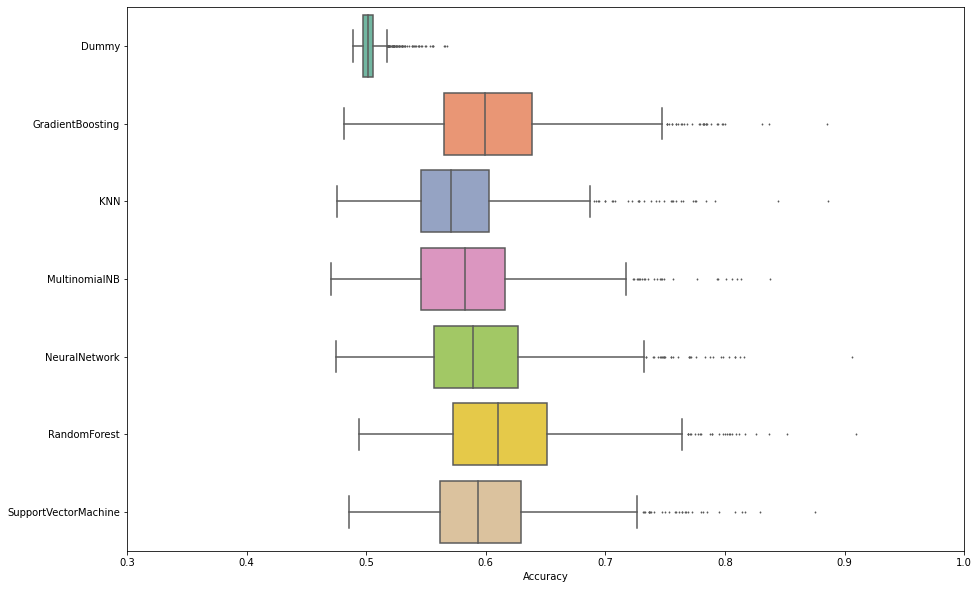

In [ ]:
# Box plot
accuracy_data = one_vs_all_assessment.loc["test_accuracy_mean",:].unstack()
ax = sns.boxplot(data=accuracy_data, orient="h", palette="Set2", showfliers = True, flierprops = {"markerfacecolor" :'0.50', "markersize": 1}) # To hide outliers set showfliers to False. Flierprops to change properties of outliers
ax.set_xlabel("Accuracy")
ax.set(xlim=(0.3, 1.0))
ax.figure.set_size_inches(15, 10)

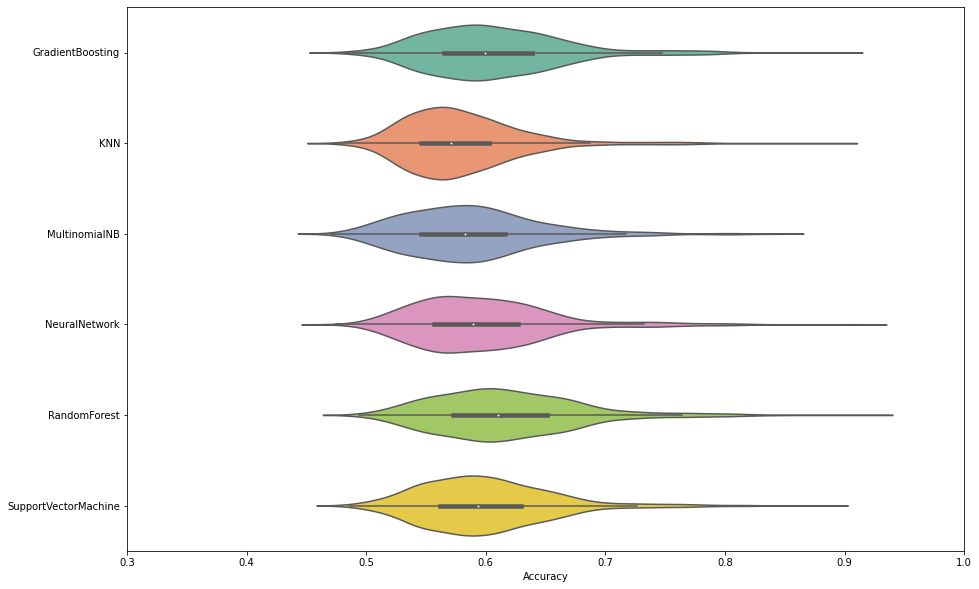

In [ ]:
# Violin plot. Just for fun.
accuracy_data = one_vs_all_assessment.loc["test_accuracy_mean",:].unstack()
accuracy_data.drop("Dummy", axis=1, inplace=True) #The distribution of the values for the Dummy Classifier make the others looks very thin
ax = sns.violinplot(data=accuracy_data, orient="h", palette="Set2")
ax.set_xlabel("Accuracy")
ax.set(xlim=(0.3, 1.0))
ax.figure.set_size_inches(15, 10)

#### F1

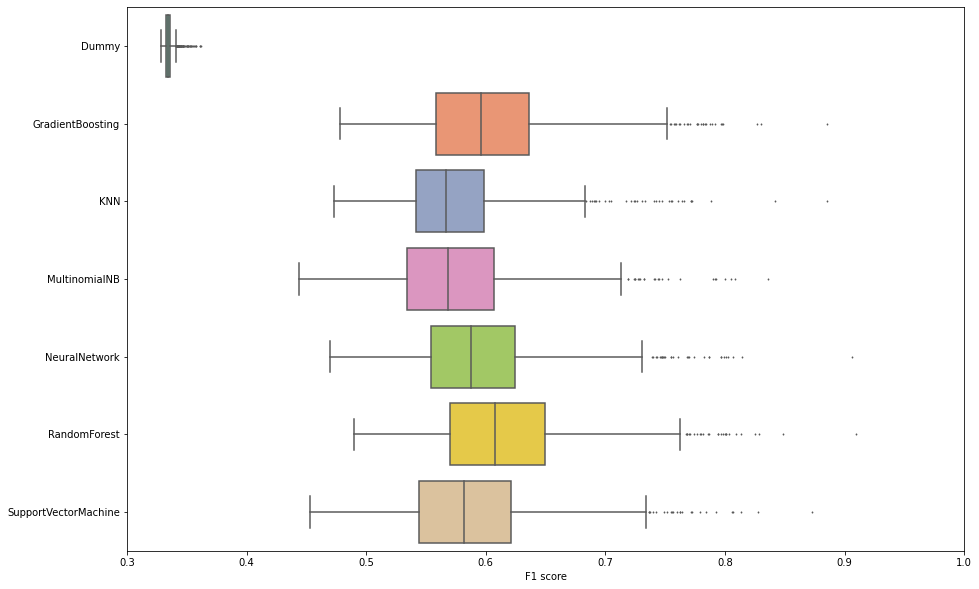

In [ ]:
# Box plot
f1_data = one_vs_all_assessment.loc["test_f1_macro_mean",:].unstack()
ax = sns.boxplot(data=f1_data, orient="h", palette="Set2", showfliers = True, flierprops = {"markerfacecolor" :'0.50', "markersize": 1}) # To hide outliers set showfliers to False. Flierprops to change properties of outliers
ax.set_xlabel("F1 score")
ax.set(xlim=(0.3, 1.0))
ax.figure.set_size_inches(15, 10)

#### ROC-AUC

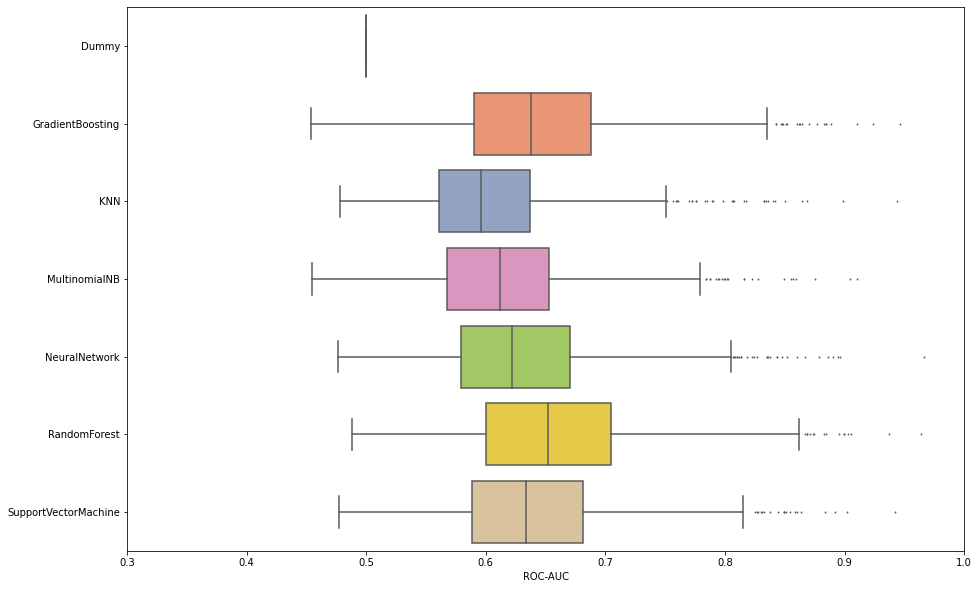

In [ ]:
# Box plot
rocauc_data = one_vs_all_assessment.loc["test_roc_auc_mean",:].unstack()
ax = sns.boxplot(data=rocauc_data, orient="h", palette="Set2", showfliers = True, flierprops = {"markerfacecolor" :'0.50', "markersize": 1}) # To hide outliers set showfliers to False. Flierprops to change properties of outliers
ax.set_xlabel("ROC-AUC")
ax.set(xlim=(0.3, 1.0))
ax.figure.set_size_inches(15, 10)

# Desease-related functions predictions 

**IMPORTANT**: for this analysis profiling matrix must correspond to the HUMAN profiling matrix.

Assess the Machine Learning algorithm at predicting diseases genes. 

Preferably a disease with a high phylogenetic signature. For instance neurodegenerative diseases.

Disease genes dataset are retrieved from: https://www.disgenet.org/home/
Some diseases identifiers to try:
* Alzheimer disease: C0002395 
* Parkinson: C0030567
* Autism Spectrum Disorder: C1510586

In [ ]:
# human Phylogenetic Matrix without GO terms
human_pp_matrix = profiling_matrix.drop(columns=["GO_IDs"], axis=1, errors="ignore")
human_pp_matrix

,189518,85962,208964,122586,83333,272561,226186,190304,324602,1111708,243230,224308,83332,100226,243273,243232,188937,64091,273057,243274,3055,3218,3702,39947,4577,284812,559292,284591,367110,665079,214684,237631,418459,237561,5664,5722,184922,36329,5888,6239,6412,6945,7070,7165,7227,7719,7739,7955,8090,8364,9031,9595,9598,9615,9913,10090,10116,13616,321614,289376,251221,35128,243231,44689,45351,224324,81824,684364,164328,243090,69014,436308,374847,515635,330879,224911,9606,7918
Q96T66,1,0,1,0,1,0,1,1,1,1,0,1,1,1,0,0,0,0,0,1,1,4,0,0,1,1,2,1,1,1,0,1,1,1,1,2,0,0,0,0,1,1,1,2,1,0,1,1,0,0,0,1,1,1,1,1,0,1,1,1,1,0,1,1,1,1,1,0,1,1,0,0,0,1,1,0,0,0
Q6IQ20,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,1,0,0,0,0,0,1,1,1,1,0,4,0,1,0,0,0,1,0,2,0,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,2,3,0,0,0,0,0,0,0,0,0,3,0,0,0
Q9H3J6,2,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,1,0,1,0,0,0,1,1,1,1,0,1,1,1,0,1,0,1,0,1,1,1,1,1,1,1,0,1,2,1,0,2,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0
Q14397,1,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,1,1,0,1,1,1,0,1,1,0,1,1,1,1,2,0,0,0,0,0,0,0,0,0,0,0
Q8NFV4,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,1,1,0,1,1,1,1,1,0,1,0,2,1,1,0,1,0,2,1,1,1,0,2,1,1,1,1,0,1,1,1,1,1,1,1,3,1,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A6NED7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0
M0R036,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
O14598,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
Q5T7P6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


## Retrieve disease genes

In [ ]:
# Check specifications on https://www.disgenet.org/api/ 

import requests
import pandas as pd
from io import StringIO

token = "01614f8e264121ffd06e93d9a9056385da7be7b4" 
disease_id = "C1510586" 
endpoint = f"https://www.disgenet.org/api/gda/disease/{disease_id}"
params = {
    #'min_score': 0.5,
    'format': 'tsv'
}
response = requests.get(endpoint, params=params, headers={"Authorization": f"Bearer {token}"})
response.raise_for_status()
gda_dataset = pd.read_table(StringIO(response.text), header=0)
gda_dataset    

,disease_name,disease_semantic_type,uniprotid,el,geneid,year_final,disease_class_name,gene_symbol,disease_class,protein_class_name,diseaseid,gene_dsi,gene_pli,protein_class,score,year_initial,source,ei,gene_dpi,disease_type
0,Autism Spectrum Disorders,Mental or Behavioral Dysfunction,Q9HCK8,definitive,57680,2020.0,Mental Disorders,CHD8,F03,NaN,C1510586,0.656,1.000000e+00,NaN,0.80,2012.0,ALL,0.974,0.577,disease
1,Autism Spectrum Disorders,Mental or Behavioral Dysfunction,P58401;Q9P2S2,moderate,9379,2018.0,Mental Disorders,NRXN2,F03,NaN,C1510586,0.769,9.993400e-01,NaN,0.74,2011.0,ALL,1.000,0.308,disease
2,Autism Spectrum Disorders,Mental or Behavioral Dysfunction,Q9UHC6,NaN,26047,2020.0,Mental Disorders,CNTNAP2,F03,NaN,C1510586,0.530,2.867300e-09,NaN,0.70,2008.0,ALL,0.976,0.846,disease
3,Autism Spectrum Disorders,Mental or Behavioral Dysfunction,Q9BYB0,NaN,85358,2020.0,Mental Disorders,SHANK3,F03,NaN,C1510586,0.550,1.000000e+00,NaN,0.70,2007.0,ALL,0.976,0.731,disease
4,Autism Spectrum Disorders,Mental or Behavioral Dysfunction,Q9NZ94,strong,54413,2019.0,Mental Disorders,NLGN3,F03,NaN,C1510586,0.653,9.764100e-01,NaN,0.60,2003.0,ALL,0.960,0.462,disease
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1066,Autism Spectrum Disorders,Mental or Behavioral Dysfunction,Q5VV43,NaN,9856,2016.0,Mental Disorders,KIAA0319,F03,NaN,C1510586,0.729,3.323400e-20,NaN,0.01,2016.0,ALL,1.000,0.385,disease
1067,Autism Spectrum Disorders,Mental or Behavioral Dysfunction,Q15047,NaN,9869,2016.0,Mental Disorders,SETDB1,F03,NaN,C1510586,0.631,1.000000e+00,NaN,0.01,2016.0,ALL,1.000,0.654,disease
1068,Autism Spectrum Disorders,Mental or Behavioral Dysfunction,Q9UKI8,NaN,9874,2019.0,Mental Disorders,TLK1,F03,Kinase,C1510586,0.641,9.999900e-01,DTO_03300101,0.01,2019.0,ALL,1.000,0.577,disease
1069,Autism Spectrum Disorders,Mental or Behavioral Dysfunction,O60285,NaN,9891,2018.0,Mental Disorders,NUAK1,F03,Kinase,C1510586,0.621,9.869300e-02,DTO_03300101,0.01,2018.0,ALL,1.000,0.577,disease


In [ ]:
min_score = 0.2
gda_dataset_filtered = gda_dataset[gda_dataset["score"]>min_score] # This could also be done with the param "min score" in the request. Did it manually just for demostrative purposes.
gda_dataset_filtered

,disease_name,disease_semantic_type,uniprotid,el,geneid,year_final,disease_class_name,gene_symbol,disease_class,protein_class_name,diseaseid,gene_dsi,gene_pli,protein_class,score,year_initial,source,ei,gene_dpi,disease_type
0,Autism Spectrum Disorders,Mental or Behavioral Dysfunction,Q9HCK8,definitive,57680,2020.0,Mental Disorders,CHD8,F03,NaN,C1510586,0.656,1.000000e+00,NaN,0.80,2012.0,ALL,0.974,0.577,disease
1,Autism Spectrum Disorders,Mental or Behavioral Dysfunction,P58401;Q9P2S2,moderate,9379,2018.0,Mental Disorders,NRXN2,F03,NaN,C1510586,0.769,9.993400e-01,NaN,0.74,2011.0,ALL,1.000,0.308,disease
2,Autism Spectrum Disorders,Mental or Behavioral Dysfunction,Q9UHC6,NaN,26047,2020.0,Mental Disorders,CNTNAP2,F03,NaN,C1510586,0.530,2.867300e-09,NaN,0.70,2008.0,ALL,0.976,0.846,disease
3,Autism Spectrum Disorders,Mental or Behavioral Dysfunction,Q9BYB0,NaN,85358,2020.0,Mental Disorders,SHANK3,F03,NaN,C1510586,0.550,1.000000e+00,NaN,0.70,2007.0,ALL,0.976,0.731,disease
4,Autism Spectrum Disorders,Mental or Behavioral Dysfunction,Q9NZ94,strong,54413,2019.0,Mental Disorders,NLGN3,F03,NaN,C1510586,0.653,9.764100e-01,NaN,0.60,2003.0,ALL,0.960,0.462,disease
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,Autism Spectrum Disorders,Mental or Behavioral Dysfunction,Q13177,NaN,5062,2018.0,Mental Disorders,PAK2,F03,Kinase,C1510586,0.653,9.716900e-01,DTO_03300101,0.21,2018.0,ALL,1.000,0.538,disease
112,Autism Spectrum Disorders,Mental or Behavioral Dysfunction,Q01650,NaN,8140,2020.0,Mental Disorders,SLC7A5,F03,Transporter,C1510586,0.513,2.350500e-01,DTO_05007405,0.21,2020.0,ALL,1.000,0.808,disease
113,Autism Spectrum Disorders,Mental or Behavioral Dysfunction,Q9UQM7,NaN,815,2018.0,Mental Disorders,CAMK2A,F03,Kinase,C1510586,0.612,9.984500e-01,DTO_03300101,0.21,2018.0,ALL,1.000,0.538,disease
114,Autism Spectrum Disorders,Mental or Behavioral Dysfunction,O15013,NaN,9639,2018.0,Mental Disorders,ARHGEF10,F03,Enzyme,C1510586,0.729,6.773900e-30,DTO_05007624,0.21,2018.0,ALL,1.000,0.577,disease


In [ ]:
disease_genes = gda_dataset_filtered["uniprotid"].dropna()

In [ ]:
# Automatize process above
import requests
import pandas as pd
from io import StringIO


def get_disease_genes(disease_id: str, min_score: float, token = "01614f8e264121ffd06e93d9a9056385da7be7b4"):
  disease_id = disease_id
  endpoint = f"https://www.disgenet.org/api/gda/disease/{disease_id}"
  params = {
      'format': 'tsv'
  }
  response = requests.get(endpoint, params=params, headers={"Authorization": f"Bearer {token}"})
  response.raise_for_status()
  gda_dataset = pd.read_table(StringIO(response.text), header=0)
  gda_dataset_filtered = gda_dataset[gda_dataset["score"]>min_score]
  disease_genes = gda_dataset_filtered["uniprotid"].dropna()
  print(f"Disease genes (after being filtered): {len(disease_genes)} out of {len(gda_dataset)} total disease genes retrieved.")
  return disease_genes

## Prepare training dataset

In [ ]:
# Add label column
human_pp_matrix["Pathogenic"] = human_pp_matrix.index.map(lambda x: 1 if x in set(disease_genes) else 0)
human_pp_matrix

,189518,85962,208964,122586,83333,272561,226186,190304,324602,1111708,243230,224308,83332,100226,243273,243232,188937,64091,273057,243274,3055,3218,3702,39947,4577,284812,559292,284591,367110,665079,214684,237631,418459,237561,5664,5722,184922,36329,5888,6239,6412,6945,7070,7165,7227,7719,7739,7955,8090,8364,9031,9595,9598,9615,9913,10090,10116,13616,321614,289376,251221,35128,243231,44689,45351,224324,81824,684364,164328,243090,69014,436308,374847,515635,330879,224911,7918,isMitochondrial,Pathogenic
Q96T66,1,0,1,0,1,0,1,1,1,1,0,1,1,1,0,0,0,0,0,1,1,4,0,0,1,1,2,1,1,1,0,1,1,1,1,2,0,0,0,0,1,1,1,2,1,0,1,1,0,0,0,1,1,1,1,1,0,1,1,1,1,0,1,1,1,1,1,0,1,1,0,0,0,1,1,0,0,1,0
Q6IQ20,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,1,0,0,0,0,0,1,1,1,1,0,4,0,1,0,0,0,1,0,2,0,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,2,3,0,0,0,0,0,0,0,0,0,3,0,0,0,0
Q9H3J6,2,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,1,0,1,0,0,0,1,1,1,1,0,1,1,1,0,1,0,1,0,1,1,1,1,1,1,1,0,1,2,1,0,2,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0
Q14397,1,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,1,1,0,1,1,1,0,1,1,0,1,1,1,1,2,0,0,0,0,0,0,0,0,0,0,0,0
Q8NFV4,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,1,1,0,1,1,1,1,1,0,1,0,2,1,1,0,1,0,2,1,1,1,0,2,1,1,1,1,0,1,1,1,1,1,1,1,3,1,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,2,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A6NED7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
M0R036,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
O14598,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
Q5T7P6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
import numpy as np

# Select randomly negative samples
negative_samples = human_pp_matrix[human_pp_matrix["Pathogenic"]==0]
positive_samples = human_pp_matrix[human_pp_matrix["Pathogenic"]==1]
negative_samples_subset = np.random.choice(negative_samples.index, size=positive_samples.shape[0])
negative_samples_subset

array(['Q9P1W9', 'P04085', 'P23588', 'Q49AH0', 'O00291', 'Q8NB66',
       'Q9P255', 'Q9BSW7', 'P13994', 'Q9H4A6', 'Q9BRQ5', 'Q92785',
       'P17931', 'P30626', 'Q9GZM5', 'Q96C24', 'Q13642', 'Q15643',
       'Q8NBR0', 'P41236', 'Q96BP2', 'Q9BRQ8', 'Q9BPW5', 'A6NCL2',
       'P28336', 'Q9C0H2', 'P15036', 'Q8WXI4', 'Q7Z2K8', 'O00418',
       'Q6UXZ0', 'Q9NY25', 'Q07889', 'P56645', 'Q9Y473', 'P27037',
       'O14948', 'Q6UX68', 'Q8NH42', 'Q02779', 'P38398', 'Q92979',
       'Q92551', 'P11387', 'Q9NRQ5', 'P42338', 'Q9Y2W1', 'O94913',
       'O75095', 'Q9NWT1', 'O94826', 'Q9Y2F5', 'Q9NVH6', 'Q0VD86',
       'Q8NHR9', 'A0A0A6YYL1', 'Q9H2H9', 'P11234', 'Q969U7', 'P55055',
       'A6PVI3', 'Q05195', 'P56179', 'Q9NZI7', 'Q7L5N1', 'P59998',
       'Q5JQS6', 'Q96M94', 'Q9BYQ7', 'P46060', 'P57772', 'O75526',
       'Q8WXJ9', 'Q8N587', 'Q9BXQ6', 'Q53GG5', 'Q02447', 'E7ENX8',
       'Q9ULE4', 'Q8N1B3', 'Q99592', 'O75711', 'Q9UJX4', 'O60284',
       'Q13568', 'Q49AH0', 'A0AVK6', 'Q5TYX0', 'Q9H209', '

In [ ]:
# Create training dataset
training_samples = np.concatenate([negative_samples_subset,positive_samples.index])
training_matrix = human_pp_matrix.loc[training_samples, :]
training_matrix = training_matrix.sample(frac=1)
training_matrix

,189518,85962,208964,122586,83333,272561,226186,190304,324602,1111708,243230,224308,83332,100226,243273,243232,188937,64091,273057,243274,3055,3218,3702,39947,4577,284812,559292,284591,367110,665079,214684,237631,418459,237561,5664,5722,184922,36329,5888,6239,6412,6945,7070,7165,7227,7719,7739,7955,8090,8364,9031,9595,9598,9615,9913,10090,10116,13616,321614,289376,251221,35128,243231,44689,45351,224324,81824,684364,164328,243090,69014,436308,374847,515635,330879,224911,7918,isMitochondrial,Pathogenic
Q15392,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,1,1,1,0,0,0,1,2,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,2,1,1,0,0,1,1,1,1,1,1,0,4,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1
Q0VD86,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Q86UW7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,1,0,0,0,1,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
P00439,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,3,1,1,2,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,0,0,1,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1
Q2WGN9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,3,1,1,1,1,0,0,1,1,0,0,0,1,0,1,1,1,1,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P23560,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
Q02779,0,0,0,0,0,0,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,2,0,1,0,0,0,0,0,1,3,1,1,2,0,1,1,1,1,1,0,0,1,1,1,1,1,1,0,0,0,0,0,0,1,0,2,0,1,2,0,0,0,1,1,0,0,0,0
Q9Y2W1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,2,2,0,1,1,1,1,1,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Q99581,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0,1,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
# Automate same process above so it is easy to resample several times

import numpy as np

def resample_training_matrix(human_pp_matrix, disease_genes):
  human_pp_matrix["Pathogenic"] = human_pp_matrix.index.map(lambda x: 1 if x in set(disease_genes) else 0)
  # Select randomly negative samples
  negative_samples = human_pp_matrix[human_pp_matrix["Pathogenic"]==0]
  positive_samples = human_pp_matrix[human_pp_matrix["Pathogenic"]==1]
  negative_samples_subset = np.random.choice(negative_samples.index, size=positive_samples.shape[0])

  # Create training dataset
  training_samples = np.concatenate([negative_samples_subset,positive_samples.index])
  training_matrix = human_pp_matrix.loc[training_samples, :]
  training_matrix = training_matrix.sample(frac=1)
  X_training_matrix = training_matrix.iloc[:, :-1]
  y_training_matrix = training_matrix.iloc[:, -1] 
  return X_training_matrix, y_training_matrix

## Model training

In [ ]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate

### With CrossValidation

In [ ]:
model = RandomForestClassifier(random_state=0, n_estimators=300, criterion="entropy", max_features="log2") #Use optimized parameters
X_training_matrix, y_training_matrix = resample_training_matrix(human_pp_matrix, disease_genes)
pd.DataFrame(cross_validate(model, X_training_matrix, y_training_matrix, cv=5, scoring=("accuracy", "f1", "roc_auc"), n_jobs=-1))

,fit_time,score_time,test_accuracy,test_f1,test_roc_auc
0,0.751044,0.102088,0.627907,0.600000,0.695887
1,0.742612,0.101151,0.720930,0.700000,0.670996
2,0.734155,0.096080,0.642857,0.651163,0.704082
3,0.769762,0.097106,0.547619,0.558140,0.673469
4,0.442330,0.049585,0.690476,0.723404,0.697279


In [ ]:
# Cross Validation and resampling several times

model = RandomForestClassifier(random_state=0, n_estimators=300, criterion="entropy", max_features="log2") #Use optimized parameters
resampling_times = 10
results = pd.DataFrame()
for i in range(resampling_times):
    X_training_matrix, y_training_matrix = resample_training_matrix(human_pp_matrix, disease_genes)
    results[i] = pd.DataFrame(cross_validate(model, X_training_matrix, y_training_matrix, cv=5, scoring=("accuracy", "f1", "roc_auc"), n_jobs=-1)).mean()
    # Show only one time the size of the training matrix, the other times will be the same size
    if i==0: 
        print(f"Size of training matrix {len(X_training_matrix)}\n")
results_mean = results.mean(axis=1).rename('{}_mean'.format)
results_std = results.std(axis=1).rename('{}_std'.format)
pd.concat([results_mean, results_std], axis=0).sort_index()

Size of training matrix 212



fit_time_mean         0.678493
fit_time_std          0.008377
score_time_mean       0.090665
score_time_std        0.002206
test_accuracy_mean    0.606179
test_accuracy_std     0.032013
test_f1_mean          0.609606
test_f1_std           0.026441
test_roc_auc_mean     0.643647
test_roc_auc_std      0.041031
dtype: float64

In [ ]:
# Automate process above

def assess_model_for_disease(human_pp_matrix: pd.DataFrame, disease_id: str, min_score: float, resampling_times: int):
  model = RandomForestClassifier(random_state=0, n_estimators=300, criterion="entropy", max_features="log2") #Use optimized parameters
  disease_genes = get_disease_genes(disease_id, min_score)
  results = pd.DataFrame()
  for i in range(resampling_times):
      X_training_matrix, y_training_matrix = resample_training_matrix(human_pp_matrix, disease_genes)
      results[i] = pd.DataFrame(cross_validate(model, X_training_matrix, y_training_matrix, cv=5, scoring=("accuracy", "f1", "roc_auc"), n_jobs=-1)).mean()
      if i==0: # Show only one time the size of the training matrix, the other times will be the same size
          print(f"Size of training matrix {len(X_training_matrix)}\n")
  results_mean = results.mean(axis=1).rename('{}_mean'.format)
  results_std = results.std(axis=1).rename('{}_std'.format)
  return pd.concat([results_mean, results_std], axis=0).sort_index()

#### Examples

##### **Alzheimer**

In [ ]:
assess_model_for_disease(human_pp_matrix, disease_id="C0002395", min_score=0.2, resampling_times=10)

Disease genes (after being filtered): 136 out of 3397 total disease genes retrieved.
Size of training matrix 260



fit_time_mean         0.710469
fit_time_std          0.009195
score_time_mean       0.094708
score_time_std        0.002603
test_accuracy_mean    0.571154
test_accuracy_std     0.038086
test_f1_mean          0.556903
test_f1_std           0.041053
test_roc_auc_mean     0.595311
test_roc_auc_std      0.040552
dtype: float64

##### **Parkinson**

In [ ]:
assess_model_for_disease(human_pp_matrix, disease_id="C0030567", min_score=0.2, resampling_times=10)

Disease genes (after being filtered): 108 out of 2078 total disease genes retrieved.
Size of training matrix 212



fit_time_mean         0.682776
fit_time_std          0.009004
score_time_mean       0.091733
score_time_std        0.002311
test_accuracy_mean    0.564574
test_accuracy_std     0.039743
test_f1_mean          0.548496
test_f1_std           0.039016
test_roc_auc_mean     0.598552
test_roc_auc_std      0.049221
dtype: float64

##### **Autism Spectrum Disorder**

In [ ]:
assess_model_for_disease(human_pp_matrix, disease_id="C1510586", min_score=0.2, resampling_times=10)

Disease genes (after being filtered): 115 out of 1071 total disease genes retrieved.
Size of training matrix 212



fit_time_mean         0.685811
fit_time_std          0.004775
score_time_mean       0.090439
score_time_std        0.001716
test_accuracy_mean    0.595150
test_accuracy_std     0.039108
test_f1_mean          0.603088
test_f1_std           0.037046
test_roc_auc_mean     0.643085
test_roc_auc_std      0.046478
dtype: float64

### Without Cross Validation

In [ ]:
from sklearn.model_selection import train_test_split

X_training_matrix, y_training_matrix = resample_training_matrix(human_pp_matrix, disease_genes)

X_train, X_test, y_train, y_test = train_test_split(X_training_matrix, y_training_matrix, test_size=0.20)
X_train

,189518,85962,208964,122586,83333,272561,226186,190304,324602,1111708,243230,224308,83332,100226,243273,243232,188937,64091,273057,243274,3055,3218,3702,39947,4577,284812,559292,284591,367110,665079,214684,237631,418459,237561,5664,5722,184922,36329,5888,6239,6412,6945,7070,7165,7227,7719,7739,7955,8090,8364,9031,9595,9598,9615,9913,10090,10116,13616,321614,289376,251221,35128,243231,44689,45351,224324,81824,684364,164328,243090,69014,436308,374847,515635,330879,224911,7918,isMitochondrial
Q92793,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,2,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,10,1,1,1,1,1,1,1,2,0,1,1,1,1,1,1,1,1,0,0,0,2,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
Q96DL1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,25,0,0,0,0,1,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
P00918,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,3,2,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
Q14011,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,1,1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,1,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
P78509,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9BXU1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Q9HAJ7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
O60462,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,1,2,2,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0
Q8N7X8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
model = RandomForestClassifier(random_state=0, n_estimators=300, criterion="entropy", max_features="log2") #Use optimized parameters
model.fit(X_train, y_train)
y_test_predictions = model.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, y_test_predictions))
print("Recall: ",recall_score(y_test, y_test_predictions))
print("Precision: ",precision_score(y_test, y_test_predictions))
print("F1 score: ",f1_score(y_test, y_test_predictions))
print("ROC-AUC: ",roc_auc_score(y_test, y_test_predictions))

Accuracy:  0.5813953488372093
Recall:  0.6363636363636364
Precision:  0.5833333333333334
F1 score:  0.6086956521739131
ROC-AUC:  0.58008658008658


## Predict Disease candidate genes

Given a list of genes, predict those that could be pathogenic. The model must have been trained with the version "Without Cross Validation"

In [ ]:
given_genes = gda_dataset[gda_dataset["score"]<min_score]["uniprotid"].dropna().to_list() # In this case we chose to try with those genes that below the minimun score set

In [ ]:
in_genes = set(given_genes).intersection(set(human_pp_matrix.index))
print(f"Found {len(in_genes)} out of {len(given_genes)} given genes.")
given_genes_pp = human_pp_matrix.loc[in_genes, :].drop(columns=["Pathogenic"], axis=1)
given_genes_pp

Found 842 out of 892 given genes.


,189518,85962,208964,122586,83333,272561,226186,190304,324602,1111708,243230,224308,83332,100226,243273,243232,188937,64091,273057,243274,3055,3218,3702,39947,4577,284812,559292,284591,367110,665079,214684,237631,418459,237561,5664,5722,184922,36329,5888,6239,6412,6945,7070,7165,7227,7719,7739,7955,8090,8364,9031,9595,9598,9615,9913,10090,10116,13616,321614,289376,251221,35128,243231,44689,45351,224324,81824,684364,164328,243090,69014,436308,374847,515635,330879,224911,9606,7918
P19544,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,3,0,1,0,0,1,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,2,2,0,1,1,0,1,1,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
P16471,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,1,1,1,1,1,1,1,1,2,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
Q9NR28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,2,1,0,0,1,1,1,1,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
P26358,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,4,2,7,2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2,1,0,0,1,1,0,1,1,0,0,1,1,1,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
Q8IYT4,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,1,0,1,1,0,1,1,1,2,1,0,0,0,0,0,0,0,0,0,1,2,0,0,2,0,1,1,1,1,1,1,1,1,0,0,1,1,1,0,1,1,1,1,0,0,0,1,1,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q8N0V3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,2,1,0,0,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
P08195,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,2,2,1,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
P30550,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,1,2,2,2,0,2,1,1,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
Q6Y288,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,1,1,1,1,1,1,2,2,0,1,1,1,1,1,1,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
predicted_dataset = pd.DataFrame(model.predict(given_genes_pp), index=given_genes_pp.index, columns=["LikelyPathogenic"])
candidate_genes = predicted_dataset[predicted_dataset["LikelyPathogenic"]==1]
candidate_genes


,LikelyPathogenic
P19544,1
P16471,1
P26358,1
Q8IYT4,1
P07942,1
...,...
Q9ULD6,1
P08195,1
P30550,1
Q6Y288,1


# Deprecated cells

In [ ]:
# Wrong way of performing one hot encoding 
import pandas
y_training_matrix_one_hot_encoded = pd.get_dummies(y_training_matrix["GO_IDs"].explode(), 
                                                   prefix="", prefix_sep=""
                                                   ).reset_index().groupby("index").first() # We take the first ocurrence as they all must be the same (no matter the first, last or whatever)
